In [1]:
import re
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from scipy.stats import boxcox
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

Pedal to the Metal! 


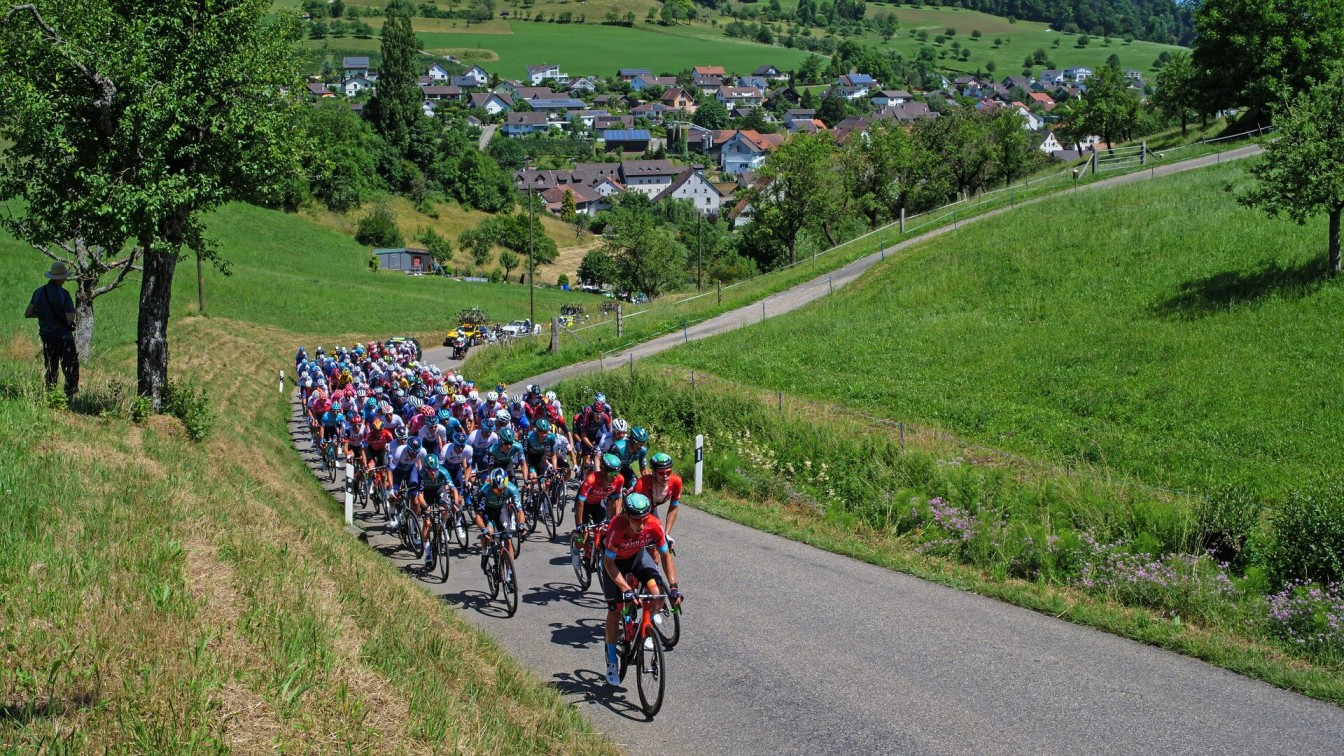


The Tour de France, which has been held since 1903 and takes place every July, is a prestigious cycling event. Lasting for three weeks, the race features challenging courses and is one of the most watched sports events globally, with over 3.5 billion viewers. Each stage presents different challenges, and generally, certain cyclists excel in particular types of stages. While some riders possess versatility across all stages (known as all-rounders), others specialize in specific areas such as one-day races or domestique roles. I'll be focusing on four distinct classifications: general classification riders, sprinters, time trialists, and climbers.

* General Classification riders aim for consistent performance across all stages to secure top positions in the overall standings.
* Sprinters specialize in explosive speed and aim for victory in flat stages with fast finishes.
* Time trialists excel in individual races against the clock, showcasing technical expertise and efficiency.
* Climbers demonstrate superior climbing abilities, dominating mountain stages with their agility and endurance.

[Photo source](https://pixabay.com/users/adege-4994132/)

In [2]:
riders = pd.read_csv('riders.csv')
stages = pd.read_csv('tdf_stages.csv')
tdf_rider = pd.read_csv('tdf_riders.csv')

# Data Understanding And Cleaning

In [3]:
riders.head()

,Unnamed: 0,Year,Rider,Rank,Time,DistanceKilometer,PersonalAvgPace,Hours,Minutes,Seconds,Team,RiderNumber,TotalSeconds,Gap,Bonus,Points,NumberStages,ListedAvgPace
0,0,1903,MAURICE GARIN,1,94h 33' 14'',2428.0,25.678,94.0,33.0,14.0,TDF 1903 ***,1,340394.0,-,NaN,NaN,6.0,25.679
1,1,1903,LUCIEN POTHIER,2,97h 32' 35'',2428.0,24.892,97.0,32.0,35.0,TDF 1903 ***,37,351155.0,+ 02h 59' 21'',NaN,NaN,6.0,25.679
2,2,1903,FERNAND AUGEREAU,3,99h 02' 38'',2428.0,24.514,99.0,2.0,38.0,TDF 1903 ***,39,356558.0,+ 04h 29' 24'',NaN,NaN,6.0,25.679
3,3,1903,RODOLPHE MULLER,4,99h 12' 44'',2428.0,24.473,99.0,12.0,44.0,TDF 1903 ***,33,357164.0,+ 04h 39' 30'',NaN,NaN,6.0,25.679
4,4,1903,JEAN-BAPTISTE FISCHER,5,99h 41' 58'',2428.0,24.353,99.0,41.0,58.0,TDF 1903 ***,12,358918.0,+ 05h 08' 44'',NaN,NaN,6.0,25.679


In [4]:
stages.head()

,Year,Date,Stage,Course,Distance,Type,Winner
0,1903,1903-07-01,1,Paris to Lyon,467 km (290 mi),Plain stage,Maurice Garin (FRA)
1,1903,1903-07-05,2,Lyon to Marseille,374 km (232 mi),Stage with mountain(s),Hippolyte Aucouturier (FRA)
2,1903,1903-07-08,3,Marseille to Toulouse,423 km (263 mi),Plain stage,Hippolyte Aucouturier (FRA)
3,1903,1903-07-12,4,Toulouse to Bordeaux,268 km (167 mi),Plain stage,Charles Laeser (SUI)
4,1903,1903-07-13,5,Bordeaux to Nantes,425 km (264 mi),Plain stage,Maurice Garin (FRA)


In [5]:
tdf_rider.head()

,Rider,General Classification,TT,Sprint,Climb,Age,Weight,Height,Country
0,Abraham Olano,5498,7739,1920,1976,27,70.0,181.0,Spain
1,Acácio Da Silva,2608,1421,4110,578,27,NaN,NaN,Portugal
2,Ad Wijnands,559,205,2750,186,22,NaN,173.0,Netherlands
3,Adelin Benoit,850,0,1549,532,27,NaN,NaN,Belgium
4,Adolfo Leoni,566,190,4460,634,33,NaN,NaN,Italy


In [6]:
# The 'Rider' column in 'riders' DataFrame is capitalized. Then, in 'stages' DataFrame, the 'Winner' column is cleaned and capitalized using a custom function, and subsequently dropped.
riders['Rider'] = riders['Rider'].str.title()

def clean_and_capitalize(name):
    return re.sub(r'\[.*?\]', '', name).split('(')[0].strip().title()

stages['Rider'] = stages['Winner'].apply(clean_and_capitalize)
stages.drop(columns=['Winner'], inplace=True)
stages.head()

,Year,Date,Stage,Course,Distance,Type,Rider
0,1903,1903-07-01,1,Paris to Lyon,467 km (290 mi),Plain stage,Maurice Garin
1,1903,1903-07-05,2,Lyon to Marseille,374 km (232 mi),Stage with mountain(s),Hippolyte Aucouturier
2,1903,1903-07-08,3,Marseille to Toulouse,423 km (263 mi),Plain stage,Hippolyte Aucouturier
3,1903,1903-07-12,4,Toulouse to Bordeaux,268 km (167 mi),Plain stage,Charles Laeser
4,1903,1903-07-13,5,Bordeaux to Nantes,425 km (264 mi),Plain stage,Maurice Garin


In [7]:
# I identified riders whose top two scores differ by less than 5% of the highest score (dominant rider type) and gathered data for verification purposes in a dataset to ensure accurate determination of the rider type.

result_dict = {}
tdf_rider['Max_Score'] = tdf_rider[['General Classification', 'TT', 'Sprint', 'Climb']].max(axis=1)

for index, row in tdf_rider.iterrows():
    max_score = row['Max_Score']
    scores = {'TT': row['TT'], 'Sprint': row['Sprint'], 'Climb': row['Climb']}
    top_two_categories = sorted(scores, key=scores.get, reverse=True)[:2]
    top_two_scores = [scores[cat] for cat in top_two_categories]
    if abs(top_two_scores[0] - top_two_scores[1]) < max_score * 0.05:
        result_dict[row['Rider']] = {
            'Top_Categories': top_two_categories,
            'Top_Scores': top_two_scores,
            'Highest_Score': max(top_two_scores)
        }

result_dict = pd.DataFrame(result_dict)
result_dict =result_dict.T
print(result_dict.shape)
result_dict

(31, 3)


,Top_Categories,Top_Scores,Highest_Score
Andrew Hampsten,"[TT, Sprint]","[2068, 1793]",2068
Bernard Labourdette,"[TT, Sprint]","[737, 646]",737
Bernard Quilfen,"[Sprint, Climb]","[105, 104]",105
Charles Crupelandt,"[Climb, Sprint]","[904, 880]",904
Charly Mottet,"[Sprint, TT]","[4228, 4095]",4228
Christian Seznec,"[Sprint, Climb]","[1170, 1120]",1170
Cyril Dessel,"[Climb, Sprint]","[515, 484]",515
David Moncoutié,"[Climb, Sprint]","[1932, 1760]",1932
Édouard Fachleitner,"[Sprint, Climb]","[529, 484]",529
Eros Poli,"[Sprint, Climb]","[109, 100]",109


In [8]:
# I determined the target variable by selecting the column with the highest value among 'General Classification', 'TT', 'Sprint', and 'Climber', and then dropped these columns from the data.
tdf_rider.rename(columns={
    'General Classification': 'GC Rider',
    'TT': 'Time Trialist',
    'Sprint': 'Sprinter',
    'Climb': 'Climber'
}, inplace=True)

tdf_rider['RiderType'] = tdf_rider[['GC Rider', 'Time Trialist', 'Sprinter', 'Climber']].idxmax(axis=1)
tdf_rider = tdf_rider.drop(['GC Rider', 'Time Trialist', 'Sprinter', 'Climber'], axis=1)
tdf_rider.head()

,Rider,Age,Weight,Height,Country,Max_Score,RiderType
0,Abraham Olano,27,70.0,181.0,Spain,7739,Time Trialist
1,Acácio Da Silva,27,NaN,NaN,Portugal,4110,Sprinter
2,Ad Wijnands,22,NaN,173.0,Netherlands,2750,Sprinter
3,Adelin Benoit,27,NaN,NaN,Belgium,1549,Sprinter
4,Adolfo Leoni,33,NaN,NaN,Italy,4460,Sprinter


In [9]:
# I examined cyclists with very close to two scores from separate sources and noticed that some were categorized differently in terms of their types. Based on the information provided in the sources, I adjusted the classifications of the riders. 
tdf_rider.loc[tdf_rider['Rider'] == 'Bernard Quilfen', 'RiderType'] = 'Climber'
tdf_rider.loc[tdf_rider['Rider'] == 'Charly Mottet', 'RiderType'] = 'Time Trialist'
tdf_rider.loc[tdf_rider['Rider'] == 'Christian Seznec', 'RiderType'] = 'Climber'
tdf_rider.loc[tdf_rider['Rider'] == 'Édouard Fachleitner', 'RiderType'] = 'Climber'
tdf_rider.loc[tdf_rider['Rider'] == 'Giuseppe Guerini', 'RiderType'] = 'Climber'
tdf_rider.loc[tdf_rider['Rider'] == 'Hippolyte Aucouturier', 'RiderType'] = 'Sprinter'
tdf_rider.loc[tdf_rider['Rider'] == 'Jacky Durand', 'RiderType'] = 'Time Trialist'
tdf_rider.loc[tdf_rider['Rider'] == 'Michael Boogerd', 'RiderType'] = 'Climber'
tdf_rider.loc[tdf_rider['Rider'] == 'Nelson Rodríguez', 'RiderType'] = 'Climber'
tdf_rider.loc[tdf_rider['Rider'] == 'Pascal Simon', 'RiderType'] = 'Climber'
tdf_rider.loc[tdf_rider['Rider'] == 'Pedro Torres', 'RiderType'] = 'Sprinter'

In [10]:
df = pd.merge(stages, riders, on=['Year','Rider'], how='inner')

del stages
del riders

df.head()

,Year,Date,Stage,Course,Distance,Type,Rider,Unnamed: 0,Rank,Time,DistanceKilometer,PersonalAvgPace,Hours,Minutes,Seconds,Team,RiderNumber,TotalSeconds,Gap,Bonus,Points,NumberStages,ListedAvgPace
0,1903,1903-07-01,1,Paris to Lyon,467 km (290 mi),Plain stage,Maurice Garin,0,1,94h 33' 14'',2428.0,25.678,94.0,33.0,14.0,TDF 1903 ***,1,340394.0,-,NaN,NaN,6.0,25.679
1,1903,1903-07-13,5,Bordeaux to Nantes,425 km (264 mi),Plain stage,Maurice Garin,0,1,94h 33' 14'',2428.0,25.678,94.0,33.0,14.0,TDF 1903 ***,1,340394.0,-,NaN,NaN,6.0,25.679
2,1903,1903-07-18,6,Nantes to Paris,471 km (293 mi),Plain stage,Maurice Garin,0,1,94h 33' 14'',2428.0,25.678,94.0,33.0,14.0,TDF 1903 ***,1,340394.0,-,NaN,NaN,6.0,25.679
3,1905,1905-07-09,1,Paris to Nancy,340 km (210 mi),Plain stage,Louis Trousselier,36,1,00h 00' 00'',2994.0,inf,0.0,0.0,0.0,TDF 1905 ***,14,0.0,-,NaN,NaN,11.0,27.107
4,1905,1905-07-11,2,Nancy to Besançon,299 km (186 mi),Stage with mountain(s),Hippolyte Aucouturier,37,2,00h 00' 00'',2994.0,inf,0.0,0.0,0.0,TDF 1905 ***,13,0.0,-,NaN,NaN,11.0,27.107


In [11]:
df.shape

(1539, 23)

In [12]:
df.isnull().sum()

Year                    0
Date                    0
Stage                   0
Course                  0
Distance                0
Type                    0
Rider                   0
Unnamed: 0              0
Rank                    0
Time                   53
DistanceKilometer       0
PersonalAvgPace        53
Hours                  53
Minutes                53
Seconds                53
Team                    0
RiderNumber             0
TotalSeconds           53
Gap                    53
Bonus                1480
Points               1486
NumberStages            0
ListedAvgPace          35
dtype: int64

In [13]:
# Due to an excessive number of null values in the 'Bonus' and 'Points' columns, I'm dropping them.
df = df.drop(['Bonus', 'Points','Unnamed: 0'], axis=1).replace([np.inf, -np.inf], np.nan).dropna()

# The parenthesized information in the 'Distance' column has been removed, leaving only the distance in kilometers.
df['Distance'] = df['Distance'].replace({'\([^)]*\)': '', '[^\d\.]': ''}, regex=True)
df = pd.merge(df, tdf_rider, on='Rider', how='inner') \
                  .sort_values(by=['Rider', 'Date']) \
                  .drop_duplicates(subset='Rider', keep='last')
print(df.shape)
# Of course, it will take some other steps to build a machine learning model, but here is the final merged dataset.
df.head()

(531, 26)


,Year,Date,Stage,Course,Distance,Type,Rider,Rank,Time,DistanceKilometer,PersonalAvgPace,Hours,Minutes,Seconds,Team,RiderNumber,TotalSeconds,Gap,NumberStages,ListedAvgPace,Age,Weight,Height,Country,Max_Score,RiderType
1132,1997,1997-07-26,20,Disneyland Paris,63.0,Individual time trial,Abraham Olano,4,00h 25' 04'',3950.0,9454.787,0.0,25.0,4.0,BANESTO,151,1504.0,+ 00h 15' 55'',22.0,39.237,27,70.0,181.0,Spain,7739,Time Trialist
128,1927,1927-07-11,18,Evian to Pontarlier,213,Team time trial,Adelin Benoit,5,203h 01' 43'',5398.0,26.587,203.0,1.0,43.0,ALCYON-DUNLOP,3,730903.0,+ 04h 45' 01'',24.0,27.224,27,NaN,NaN,Belgium,1549,Sprinter
377,1951,1951-07-29,24,Dijon to Paris,322,Plain stage,Adolphe Deledda,32,144h 29' 43'',4690.0,32.458,144.0,29.0,43.0,EST-SUD EST,103,520183.0,+ 02h 09' 29'',24.0,32.949,32,NaN,NaN,France,1606,Sprinter
999,1988,1988-07-19,16,Luz Ardiden to Pau,35,Plain stage,Adri Van Der Poel,84,86h 02' 36'',3286.0,38.190,86.0,2.0,36.0,P.D.M,18,309756.0,+ 01h 34' 43'',23.0,38.909,29,70.0,181.0,Netherlands,9212,Sprinter
624,1965,1965-07-05,13,Perpignan to Montpellier,164,Plain stage,Adriano Durante,73,118h 09' 15'',4188.0,35.445,118.0,9.0,15.0,MOLTENI-IGNIS,117,425355.0,+ 01h 27' 09'',22.0,35.886,25,NaN,NaN,Italy,3392,Sprinter


In [14]:
df['ListedAvgPace'] = df['ListedAvgPace'].astype('int')
df['Distance'] = df['Distance'].str.replace('.', '').astype(int)
df['Type'].value_counts()

Type
Plain stage                      243
Stage with mountain(s)           108
Flat stage                        36
Individual time trial             35
Hilly stage                       31
High mountain stage               18
Medium mountain stage             15
Mountain stage                    15
Team time trial                   10
Mountain time trial                5
Mountain Stage                     3
Flat Stage                         2
Stage with mountains               2
Mountain Stage (s)                 2
Plain stage with cobblestones      1
Medium mountain stage[c]           1
Stage with mountain                1
Transition stage                   1
Half Stage                         1
Intermediate stage                 1
Name: count, dtype: int64

In [15]:
# I grouped the stages in the data into broader categories.
stage_counts = df['Type'].value_counts()

category_mapping = {
    'Plain stage': 'Plain stage',
    'Flat stage': 'Plain stage',
    'Flat Stage': 'Plain stage',
    'Plain stage with cobblestones': 'Plain stage',
    'Hilly stage': 'Hilly stage',
    'Medium mountain stage': 'Mountain stage',
    'Medium mountain stage[c]': 'Mountain stage',
    'Mountain stage': 'Mountain stage',
    'Stage with mountain(s)': 'Mountain stage',
    'Stage with mountains': 'Mountain stage',
    'High mountain stage': 'Mountain stage',
    'Mountain Stage': 'Mountain stage',
    'Mountain Stage (s)': 'Mountain stage',
    'Stage with mountain': 'Mountain stage',
    'Mountain time trial': 'Time trial',
    'Mountain Stage (s)': 'Time trial',
    'Individual time trial': 'Time trial',
    'Team time trial': 'Time trial',
    'Transition stage': 'Other',
    'Half Stage': 'Other',
    'Intermediate stage': 'Other'
}

df['Type'] = df['Type'].map(category_mapping)
print(df['Type'].value_counts())
df.head()

Type
Plain stage       282
Mountain stage    163
Time trial         52
Hilly stage        31
Other               3
Name: count, dtype: int64


,Year,Date,Stage,Course,Distance,Type,Rider,Rank,Time,DistanceKilometer,PersonalAvgPace,Hours,Minutes,Seconds,Team,RiderNumber,TotalSeconds,Gap,NumberStages,ListedAvgPace,Age,Weight,Height,Country,Max_Score,RiderType
1132,1997,1997-07-26,20,Disneyland Paris,630,Time trial,Abraham Olano,4,00h 25' 04'',3950.0,9454.787,0.0,25.0,4.0,BANESTO,151,1504.0,+ 00h 15' 55'',22.0,39,27,70.0,181.0,Spain,7739,Time Trialist
128,1927,1927-07-11,18,Evian to Pontarlier,213,Time trial,Adelin Benoit,5,203h 01' 43'',5398.0,26.587,203.0,1.0,43.0,ALCYON-DUNLOP,3,730903.0,+ 04h 45' 01'',24.0,27,27,NaN,NaN,Belgium,1549,Sprinter
377,1951,1951-07-29,24,Dijon to Paris,322,Plain stage,Adolphe Deledda,32,144h 29' 43'',4690.0,32.458,144.0,29.0,43.0,EST-SUD EST,103,520183.0,+ 02h 09' 29'',24.0,32,32,NaN,NaN,France,1606,Sprinter
999,1988,1988-07-19,16,Luz Ardiden to Pau,35,Plain stage,Adri Van Der Poel,84,86h 02' 36'',3286.0,38.190,86.0,2.0,36.0,P.D.M,18,309756.0,+ 01h 34' 43'',23.0,38,29,70.0,181.0,Netherlands,9212,Sprinter
624,1965,1965-07-05,13,Perpignan to Montpellier,164,Plain stage,Adriano Durante,73,118h 09' 15'',4188.0,35.445,118.0,9.0,15.0,MOLTENI-IGNIS,117,425355.0,+ 01h 27' 09'',22.0,35,25,NaN,NaN,Italy,3392,Sprinter


In [16]:
# The columns that seem unnecessary are being removed.
df = df.drop(['Stage', 'RiderNumber','Gap','Hours','Minutes', 'Seconds','Date','Time','NumberStages'], axis=1)

# Visualizations

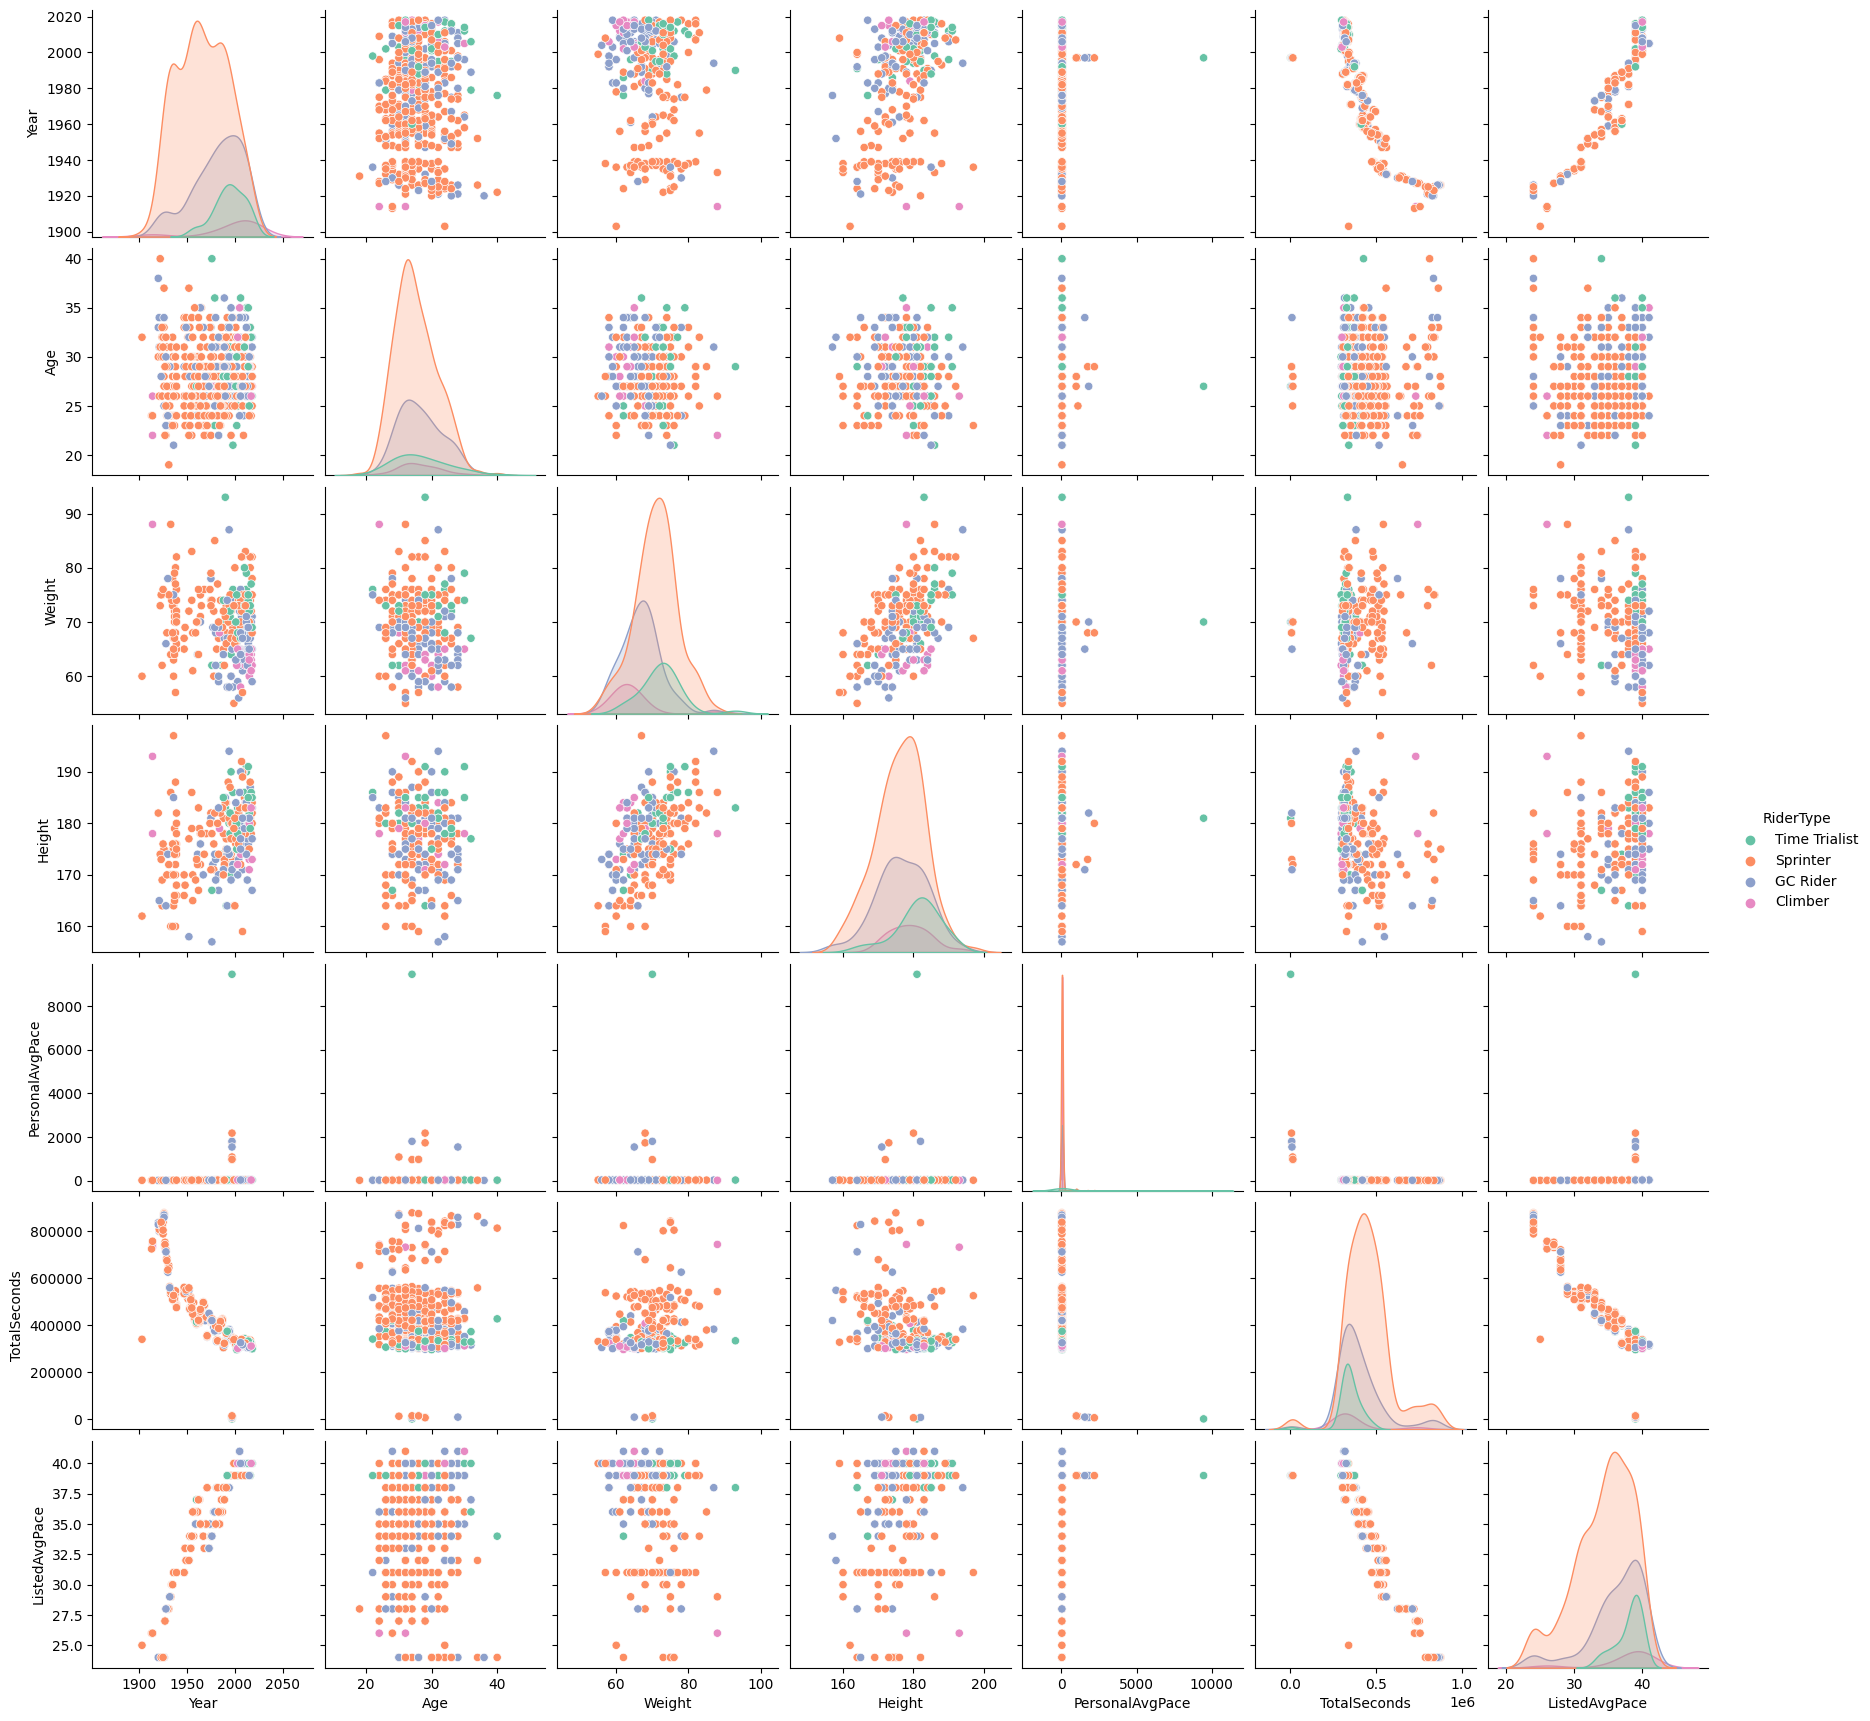

In [17]:
columns = ['Year', 'Age', 'Weight', 'Height', 'PersonalAvgPace', 'TotalSeconds', 'ListedAvgPace', 'RiderType']

sns.pairplot(df[columns], hue='RiderType', palette='Set2', diag_kind='kde', dropna=False)
plt.show()

There seems to be an issue with PersonalAvgPace.

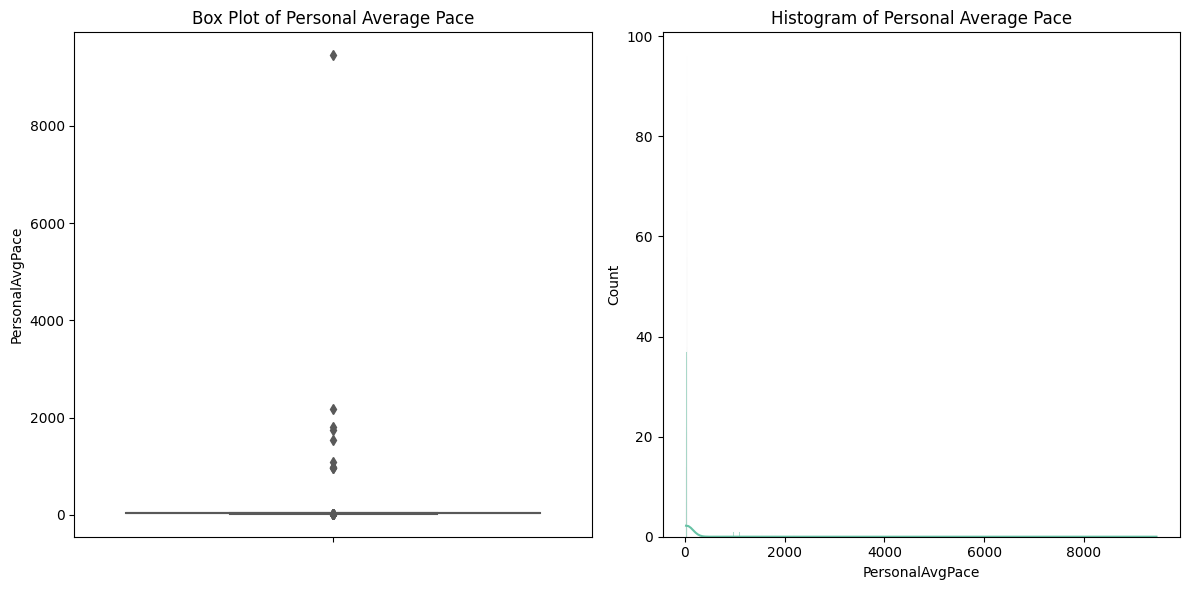

In [18]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=df, y='PersonalAvgPace', color  = '#66c2a5')
plt.title('Box Plot of Personal Average Pace')

plt.subplot(1, 2, 2)
sns.histplot(data=df, x='PersonalAvgPace', kde=True, color  = '#66c2a5')
plt.title('Histogram of Personal Average Pace')

plt.tight_layout()
plt.show()

Some extremely unlikely data points appear to be present here. They were probably misrecorded because the average pace is usually not faster than 50.

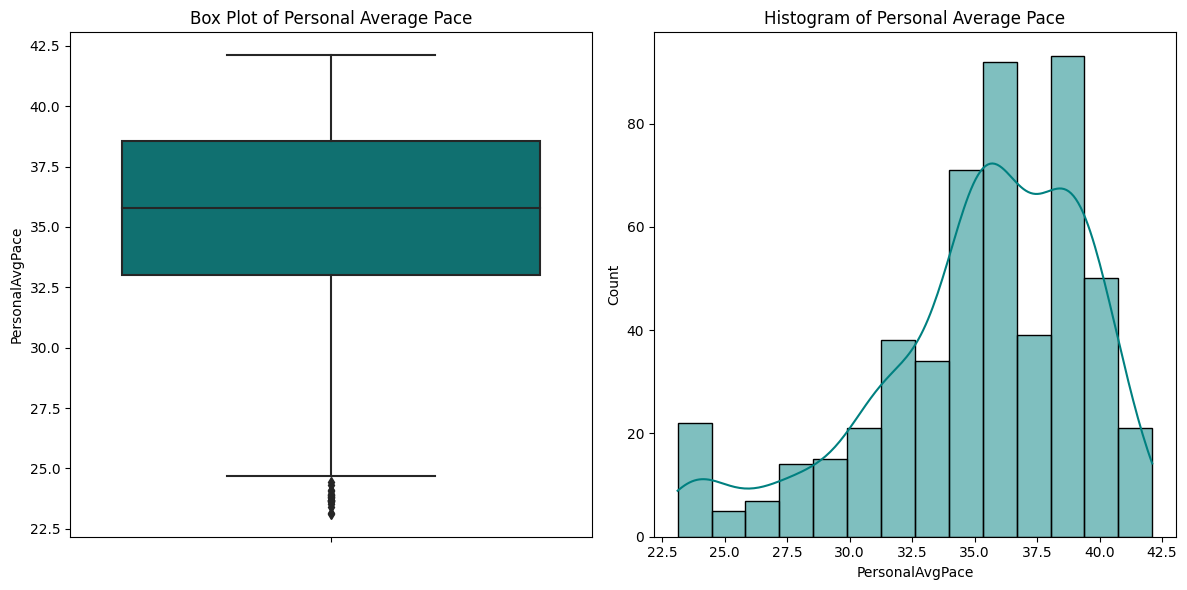

In [19]:
# Removed outliers and erroneous values from the dataset.
df = df[df['PersonalAvgPace'] <= 50]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=df, y='PersonalAvgPace', color  = 'teal')
plt.title('Box Plot of Personal Average Pace')

plt.subplot(1, 2, 2)
sns.histplot(data=df, x='PersonalAvgPace', kde=True, color  = 'teal')
plt.title('Histogram of Personal Average Pace')

plt.tight_layout()
plt.show()

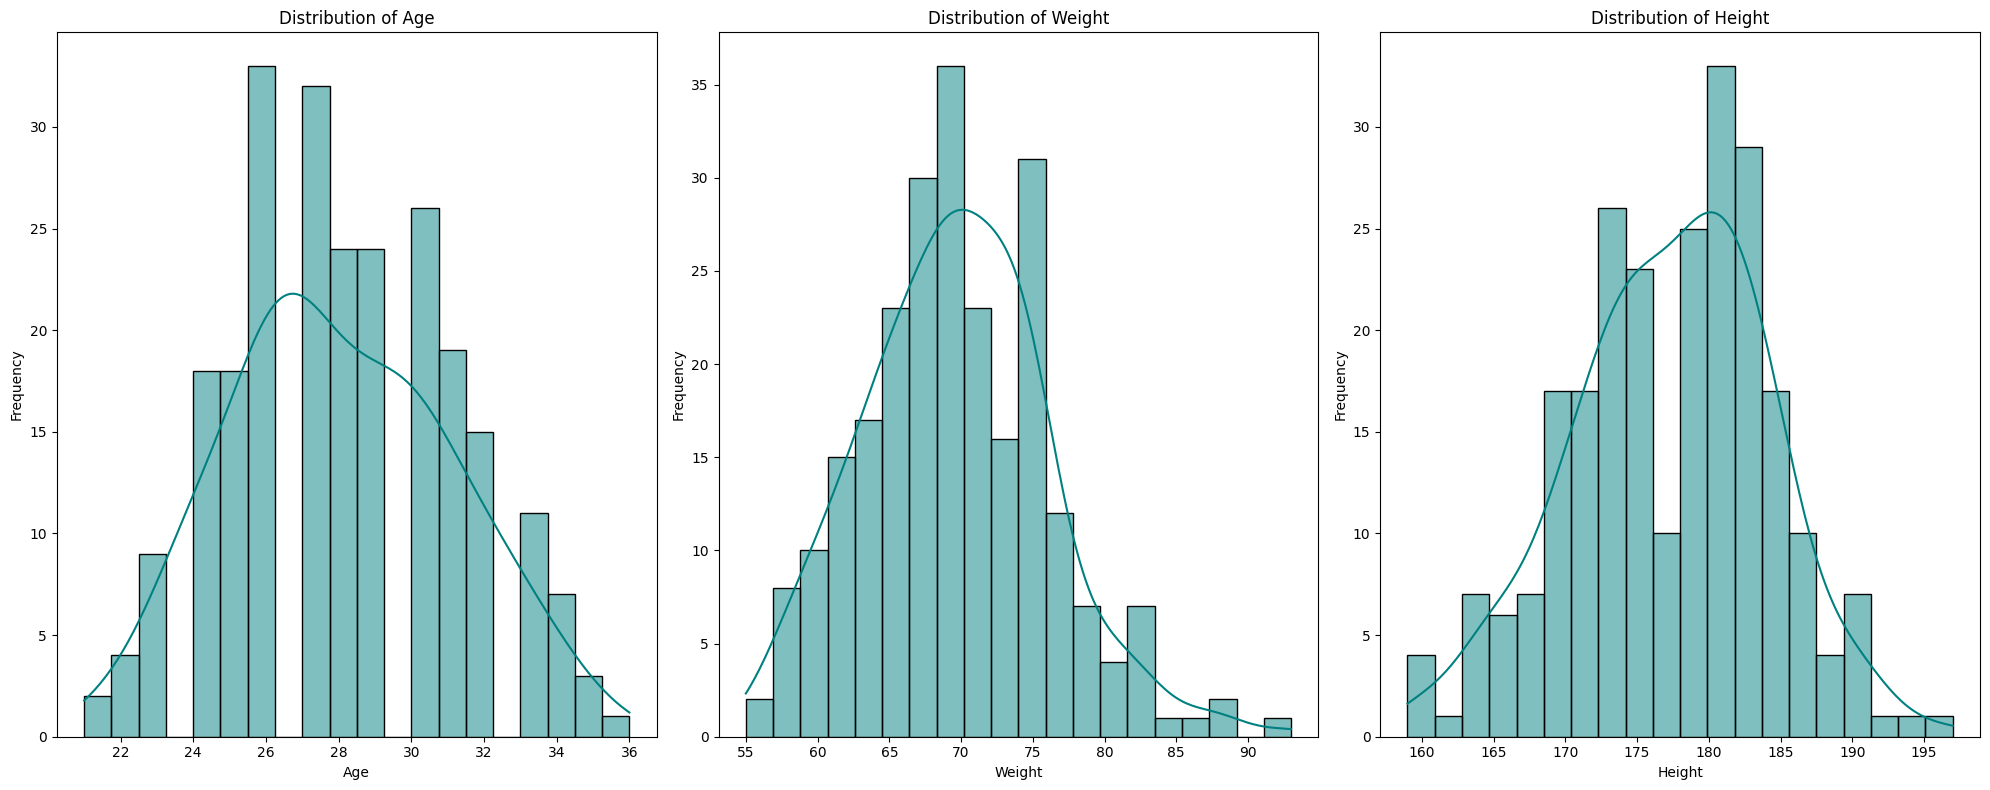

In [20]:
numeric_columns = ['Age', 'Weight', 'Height']

df_no_null = df.dropna(subset=numeric_columns)

plt.figure(figsize=(20, 8))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(1, 3, i)
    sns.histplot(data=df_no_null, x=column, bins=20, kde=True, color='teal')  
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {column}')

plt.tight_layout() 
plt.show()

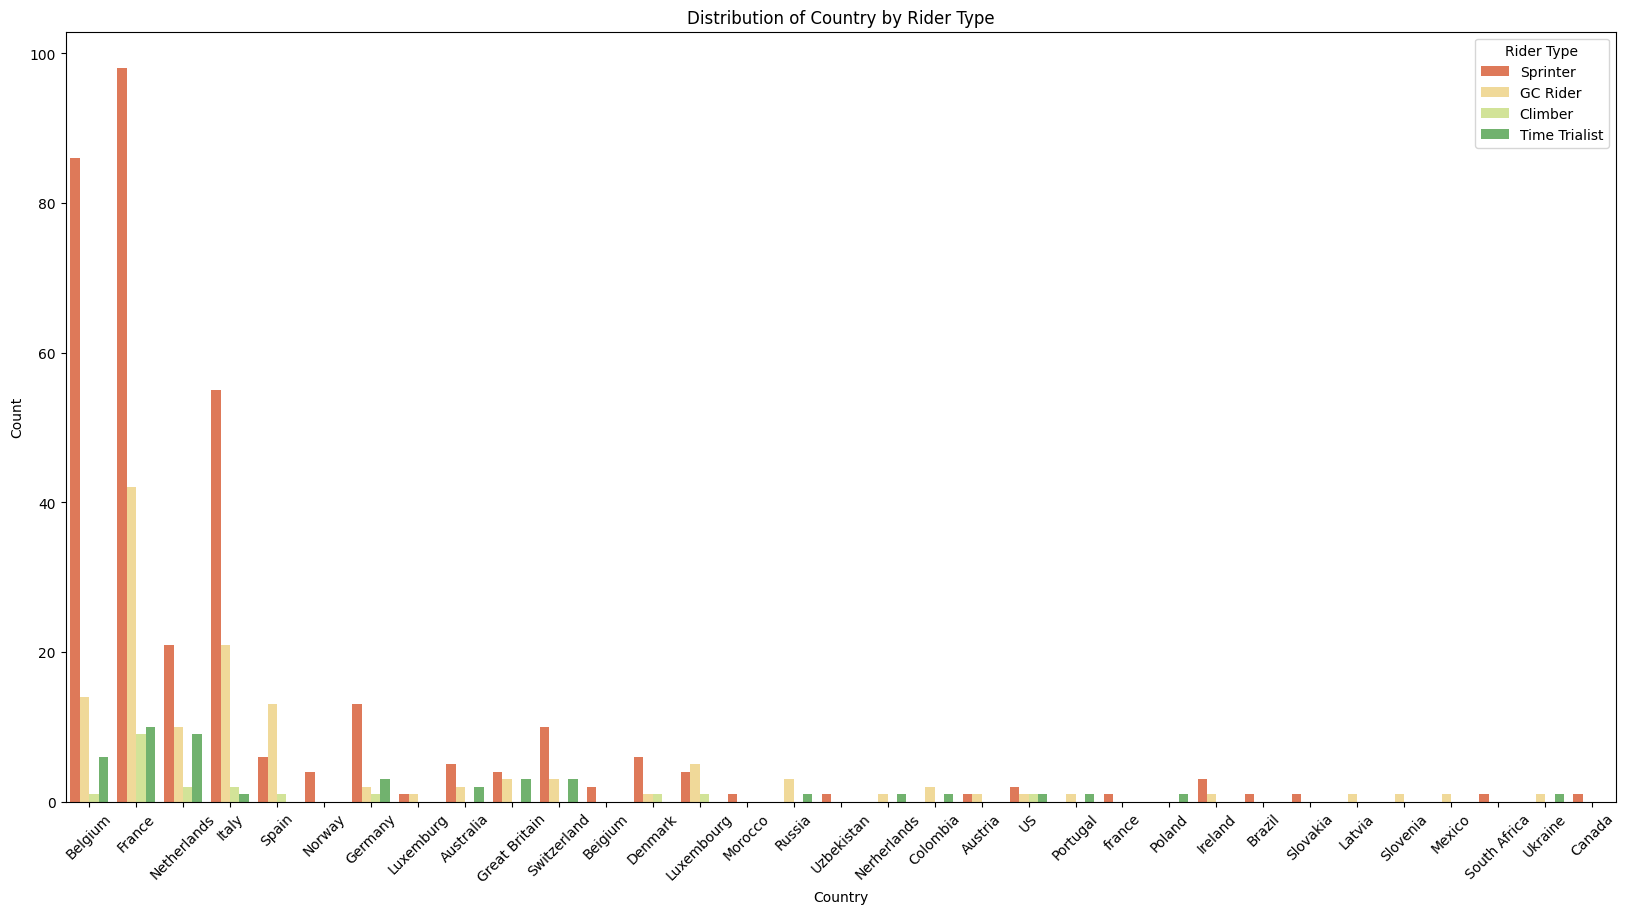

In [21]:
plt.figure(figsize=(20, 10))
sns.countplot(x='Country', hue='RiderType', data=df,palette='RdYlGn')
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Distribution of Country by Rider Type')
plt.xticks(rotation=45)
plt.legend(title='Rider Type', bbox_to_anchor=(1, 1))
plt.show()

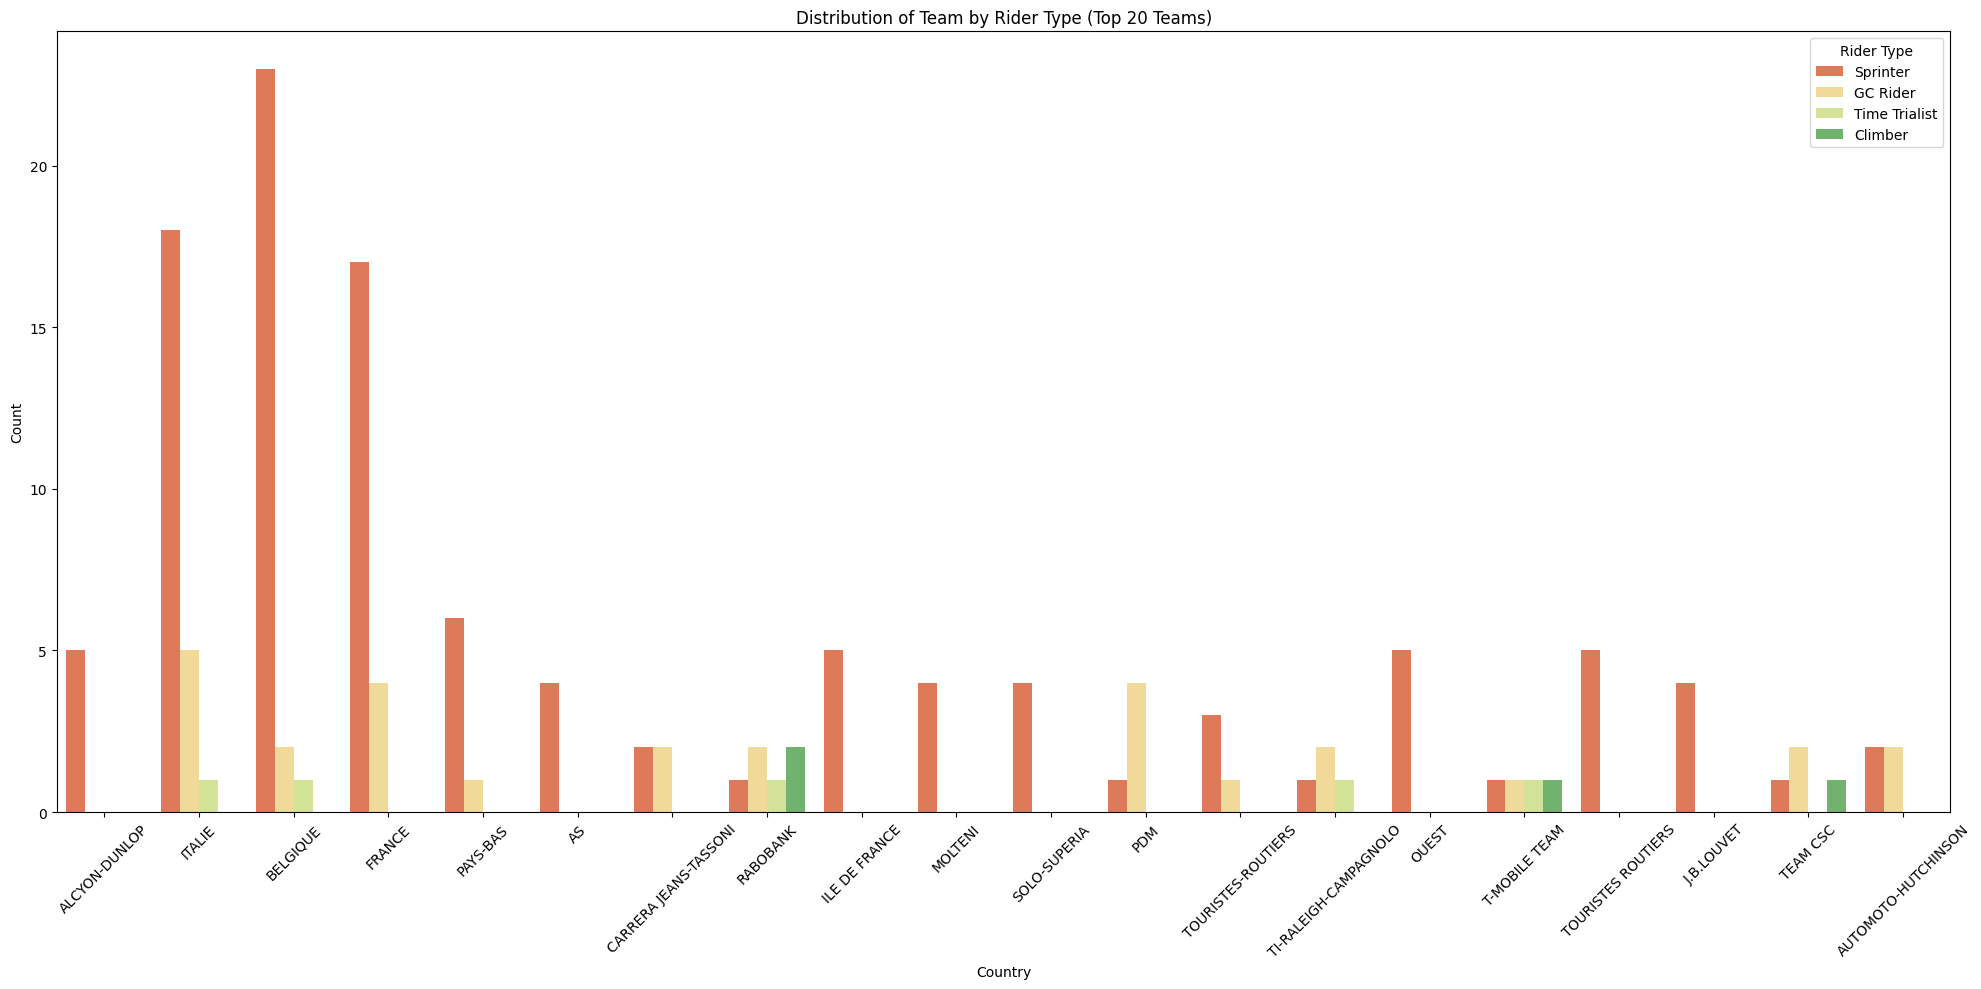

In [22]:
top_20_teams = df['Team'].value_counts().head(20).index
df_top_20 = df[df['Team'].isin(top_20_teams)]

plt.figure(figsize=(20, 10))
sns.countplot(x='Team', hue='RiderType', data=df_top_20, palette = 'RdYlGn')
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Distribution of Team by Rider Type (Top 20 Teams)')
plt.xticks(rotation=45)
plt.legend(title='Rider Type', bbox_to_anchor=(1, 1))
plt.tight_layout() #
plt.show()

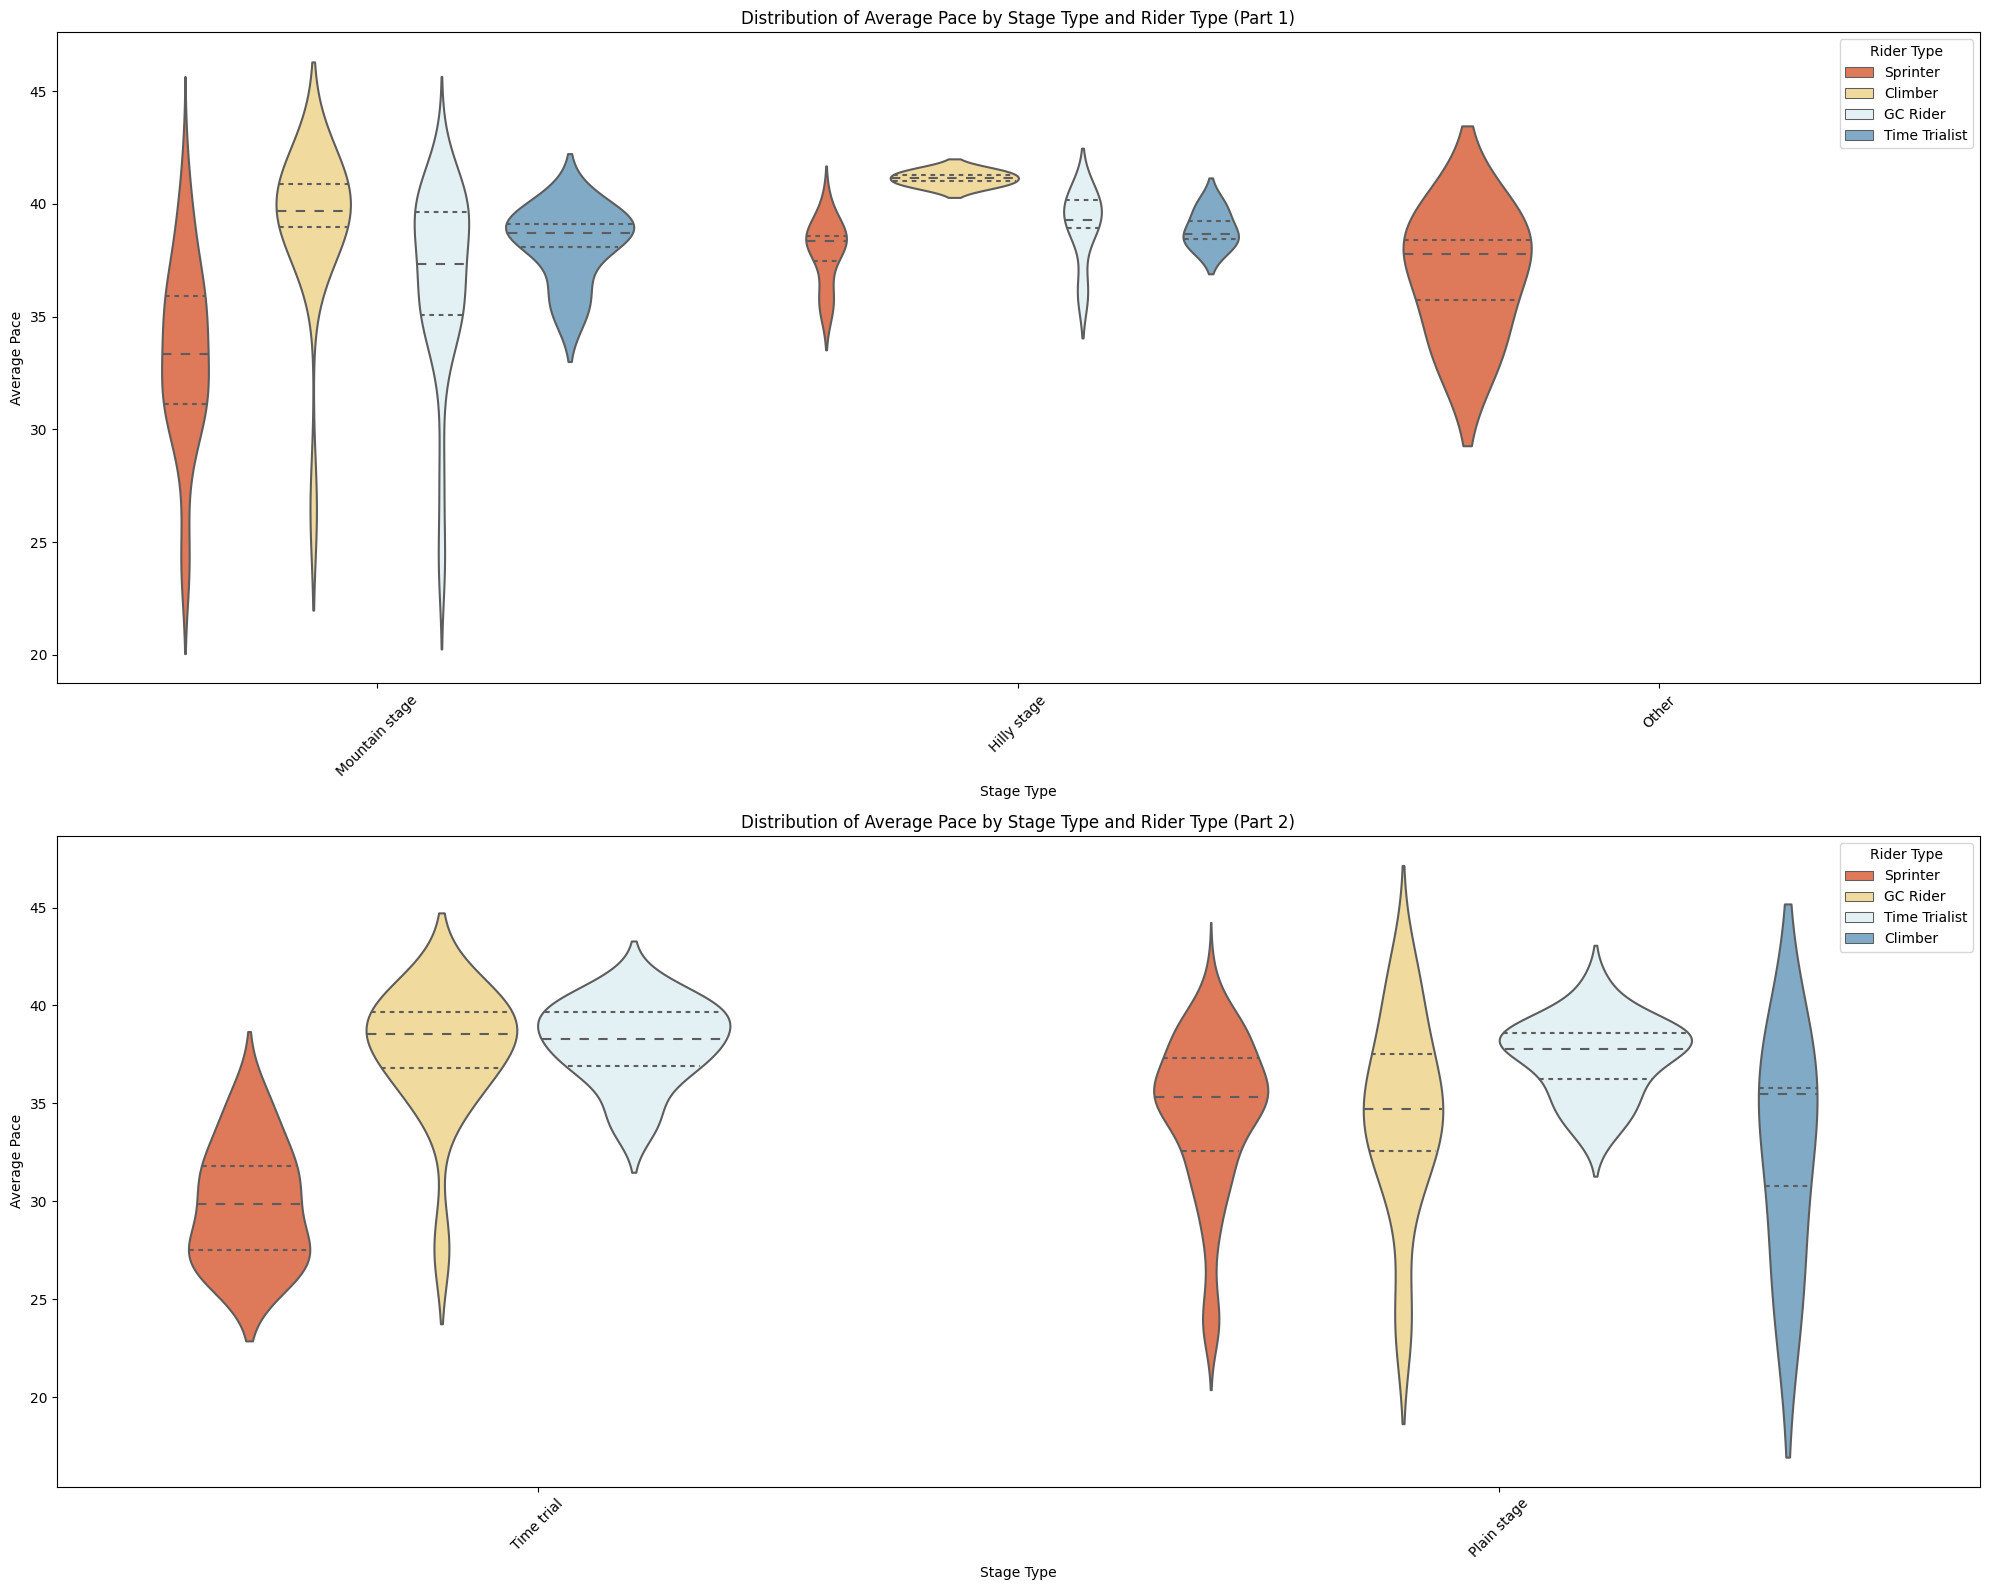

In [23]:
plt.figure(figsize=(20, 16))
plt.subplot(2, 1, 1)
sns.violinplot(x='Type', y='PersonalAvgPace', hue='RiderType', data=df[df['Type'].isin(['Hilly stage', 'Mountain stage', 'Other'])], palette='RdYlBu', inner='quartile')
plt.title('Distribution of Average Pace by Stage Type and Rider Type (Part 1)')
plt.xlabel('Stage Type')
plt.ylabel('Average Pace')
plt.legend(title='Rider Type')
plt.xticks(rotation=45)

plt.subplot(2, 1, 2)
sns.violinplot(x='Type', y='PersonalAvgPace', hue='RiderType', data=df[df['Type'].isin(['Plain stage', 'Time trial'])], palette='RdYlBu', inner='quartile')
plt.title('Distribution of Average Pace by Stage Type and Rider Type (Part 2)')
plt.xlabel('Stage Type')
plt.ylabel('Average Pace')
plt.legend(title='Rider Type')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


This dataset is small, and there are instances where certain stage categories lack winners for specific rider types. Nevertheless, the graph highlights discernible differences among riders across different types of stages. For instance, in mountain stages, climbers exhibit higher average paces compared to sprinters, whereas in plain stages, climbers tend to have lower average paces, consistent with expectations. However, it's important to note that these observations pertain to dominant rider types; individual riders may possess multiple specialties, such as being both climbers and general classification contenders simultaneously.

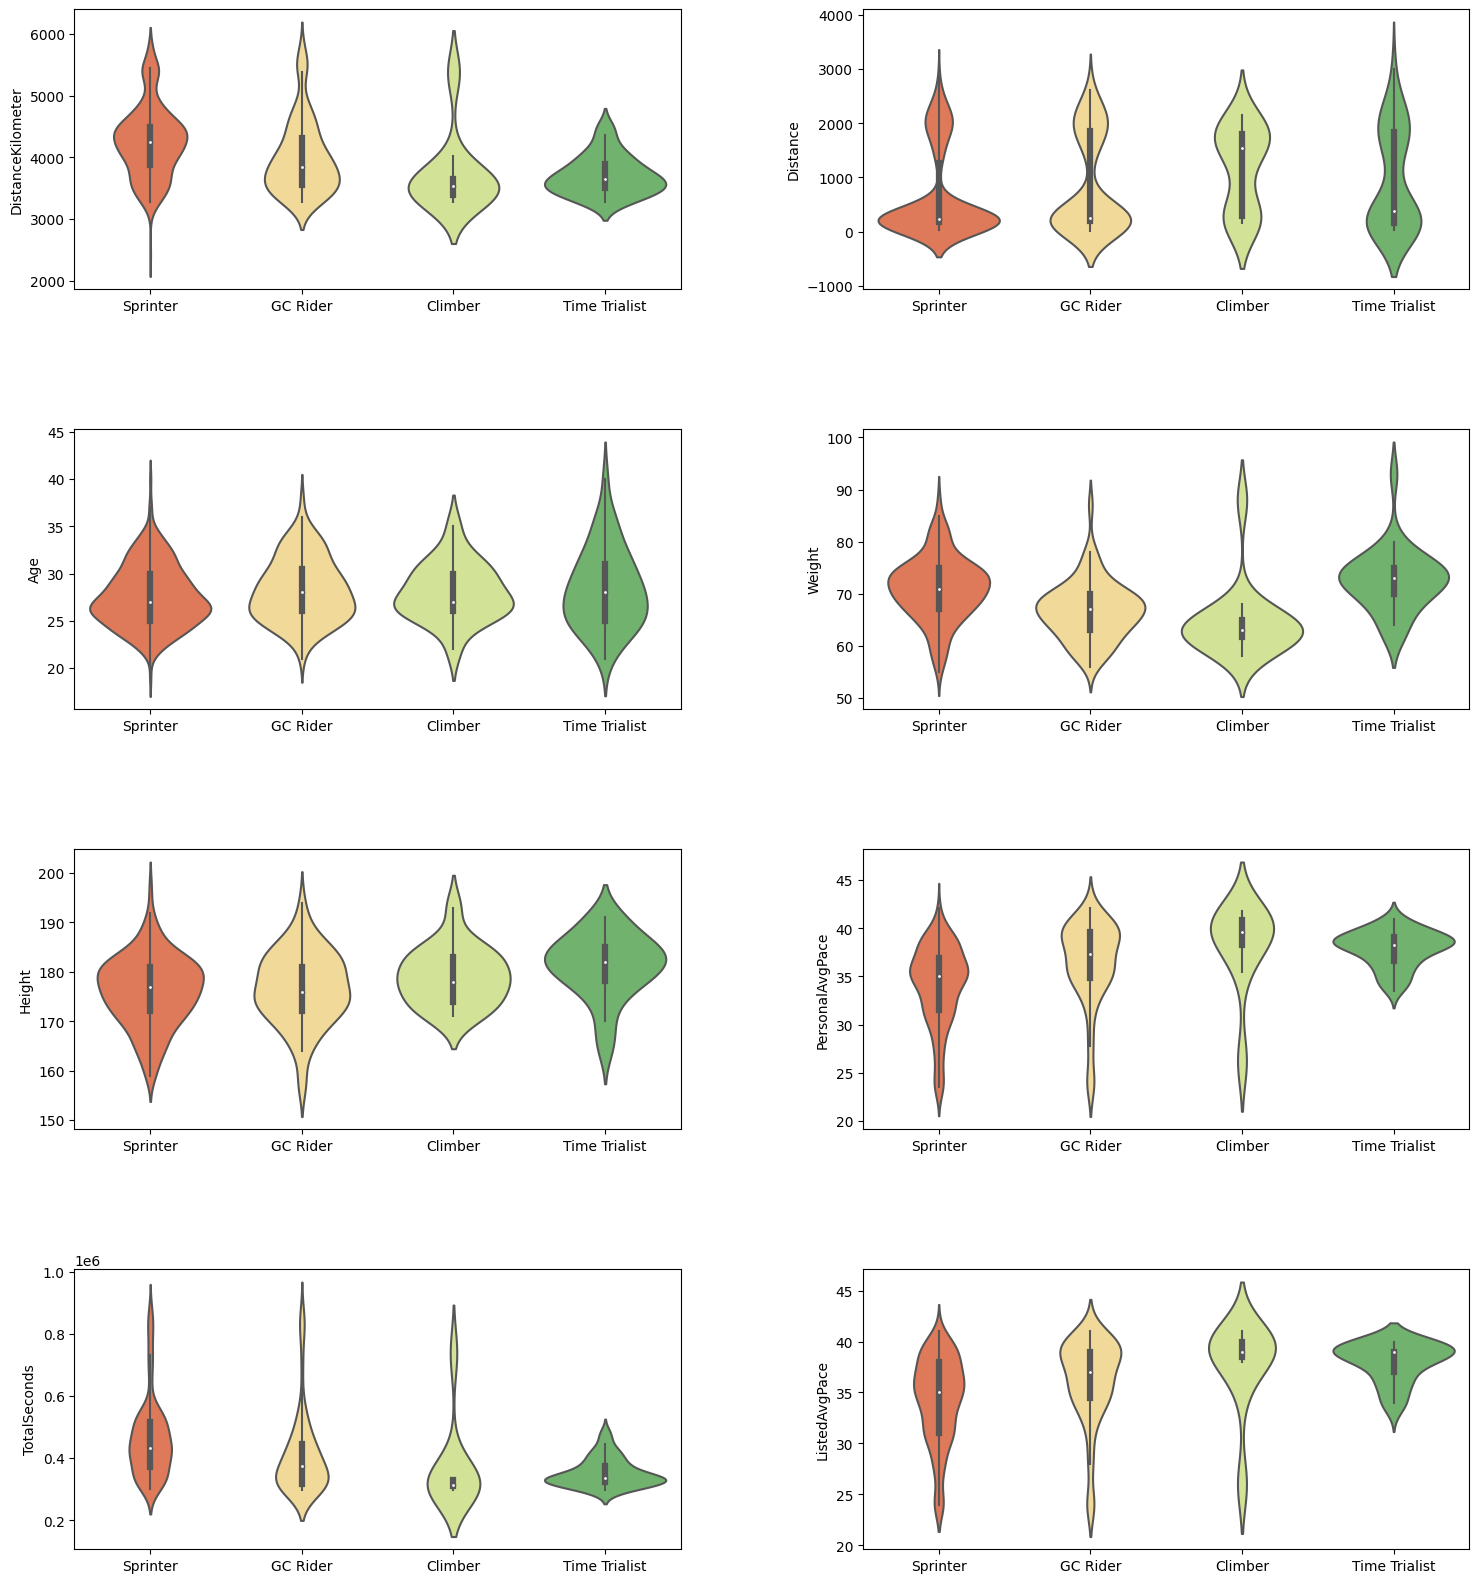

In [24]:
numeric_columns = ['DistanceKilometer','Distance', 'Age', 'Weight', 'Height', 'PersonalAvgPace', 'TotalSeconds','ListedAvgPace']

num_rows = (len(numeric_columns) + 1) // 2
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols,figsize=(18, 20))

for i, column in enumerate(numeric_columns):
    row = i // num_cols
    col = i % num_cols
    sns.violinplot(x='RiderType', y=column, data=df, ax=axes[row, col], palette = 'RdYlGn')
    axes[row, col].set_xlabel('')  

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

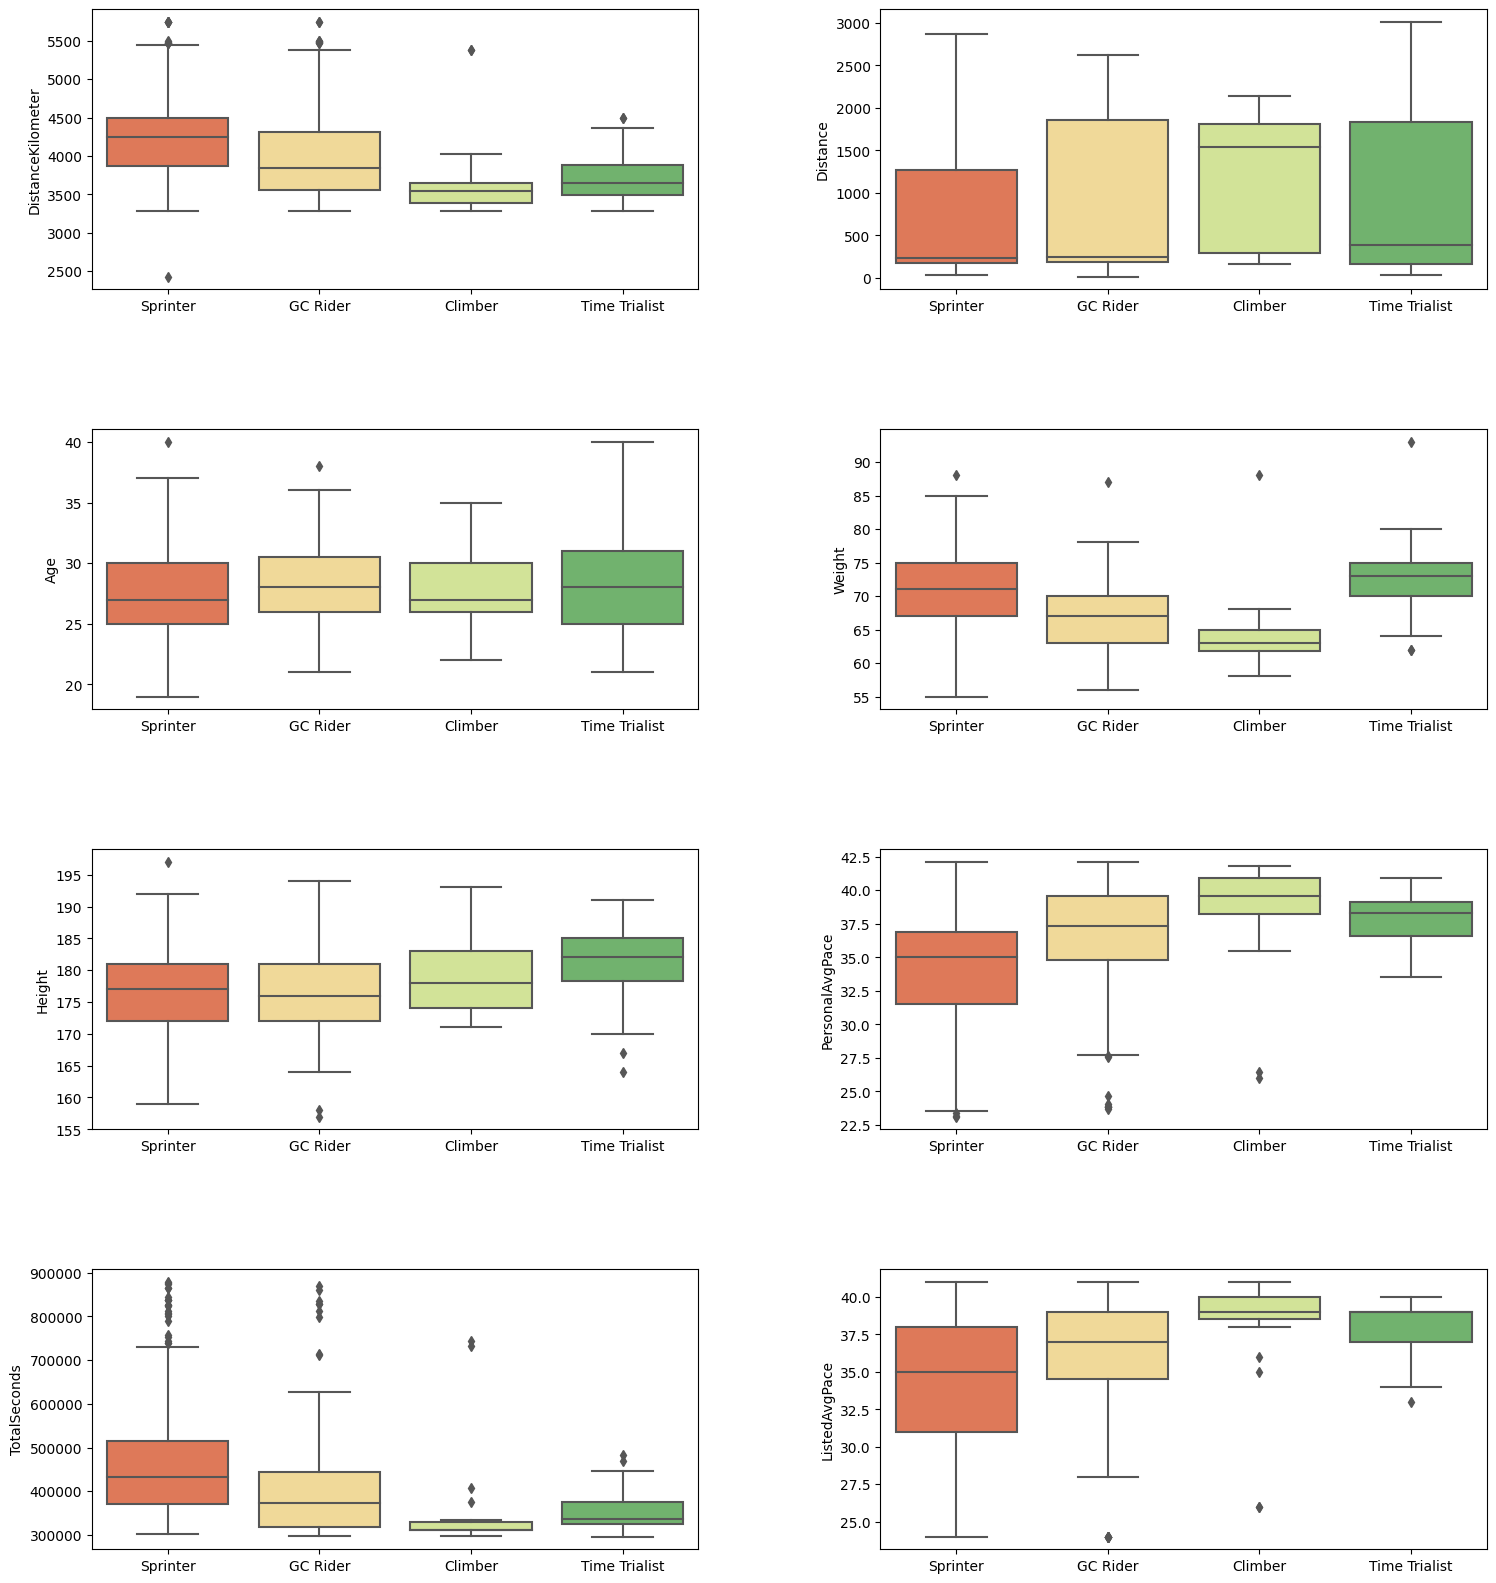

In [25]:
num_rows = (len(numeric_columns) + 1) // 2
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 20))

for i, column in enumerate(numeric_columns):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x='RiderType', y=column, data=df, ax=axes[row, col], palette = 'RdYlGn')
    axes[row, col].set_xlabel('')  

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

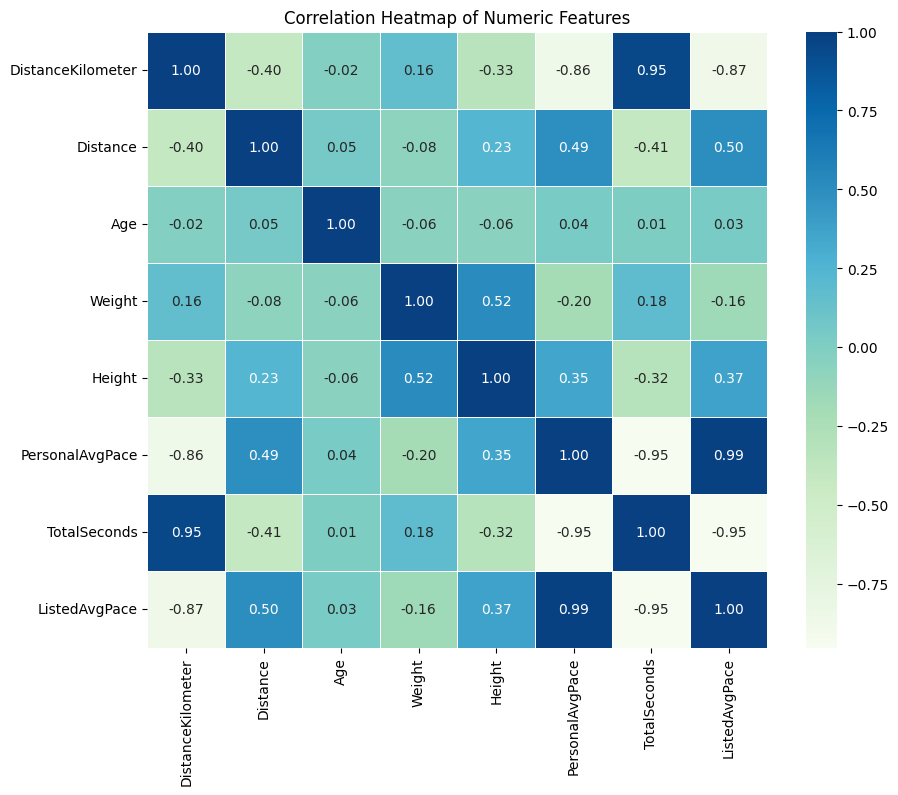

In [26]:
numeric_df = df[numeric_columns]
heatmap_data = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", linewidths=.5, cmap='GnBu')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

In [27]:
# I'm dropping ListedAvgPace and TotalSeconds since they are already explained by PersonalAvgPace to a large extent.
df.drop(['ListedAvgPace','TotalSeconds'],inplace= True, axis=1)

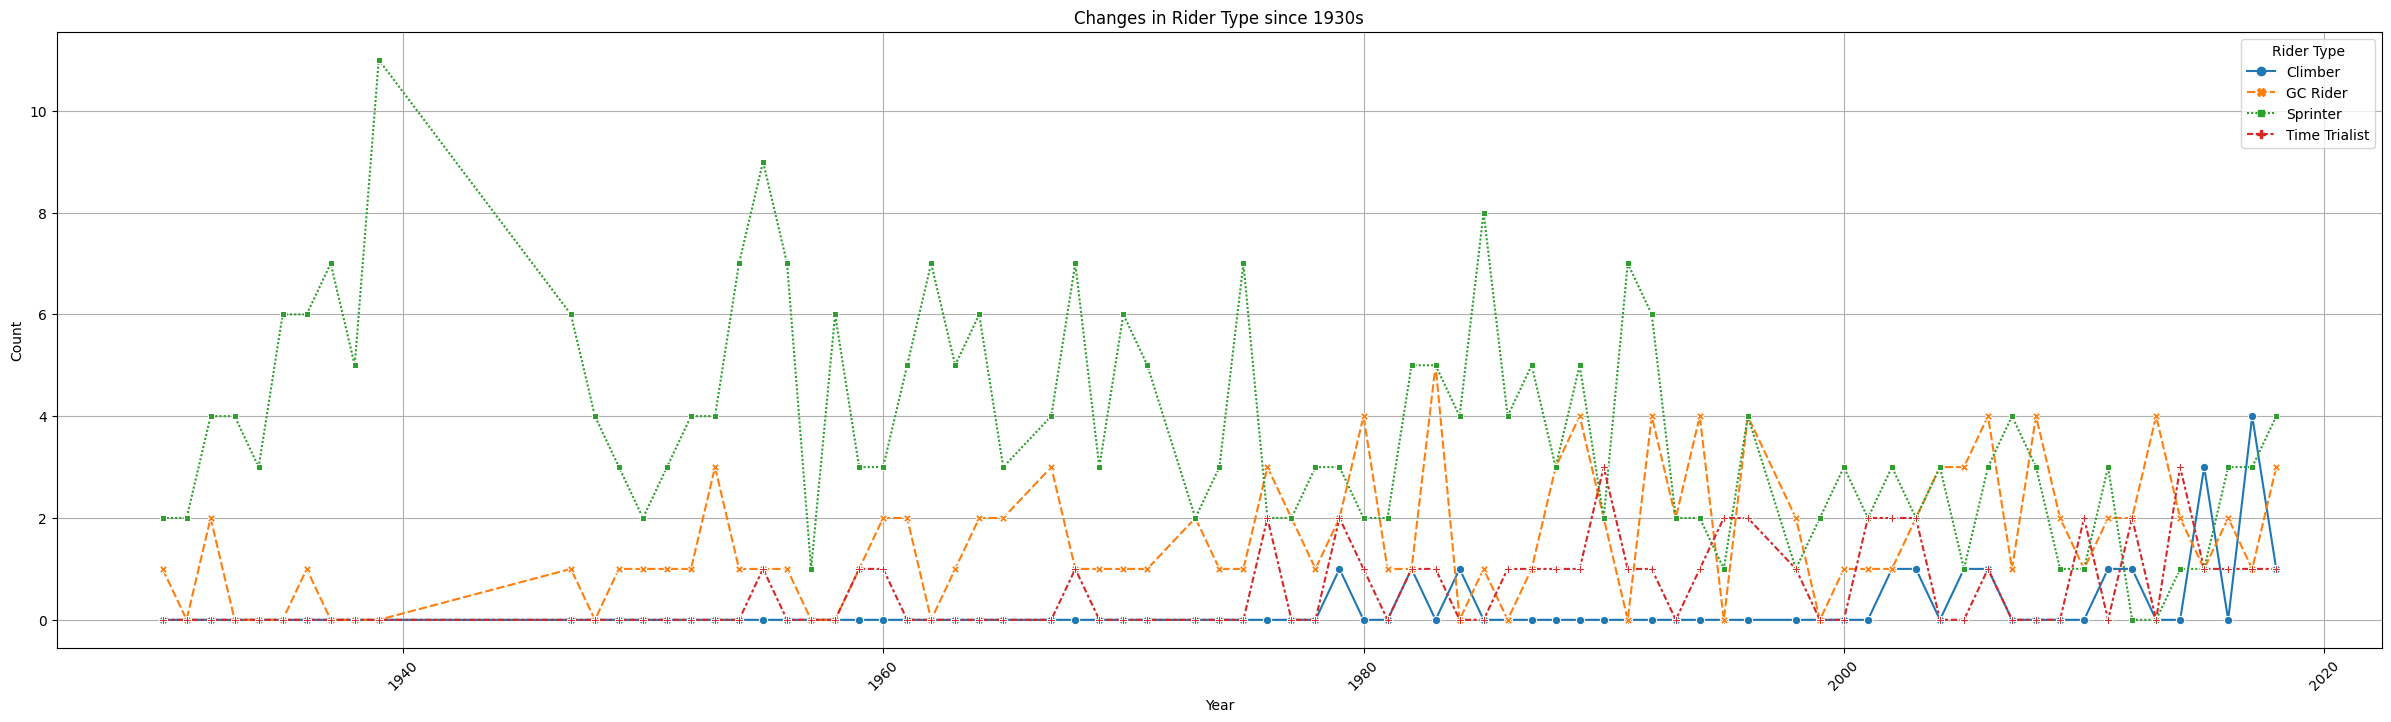

In [28]:
filtered_df = df[df['Year'] >= 1930]

yearly_rider_type_counts = filtered_df.groupby(['Year', 'RiderType']).size().unstack(fill_value=0)

plt.figure(figsize=(30, 8))
sns.lineplot(data=yearly_rider_type_counts, markers=True)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Changes in Rider Type since 1930s')
plt.legend(title='Rider Type')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

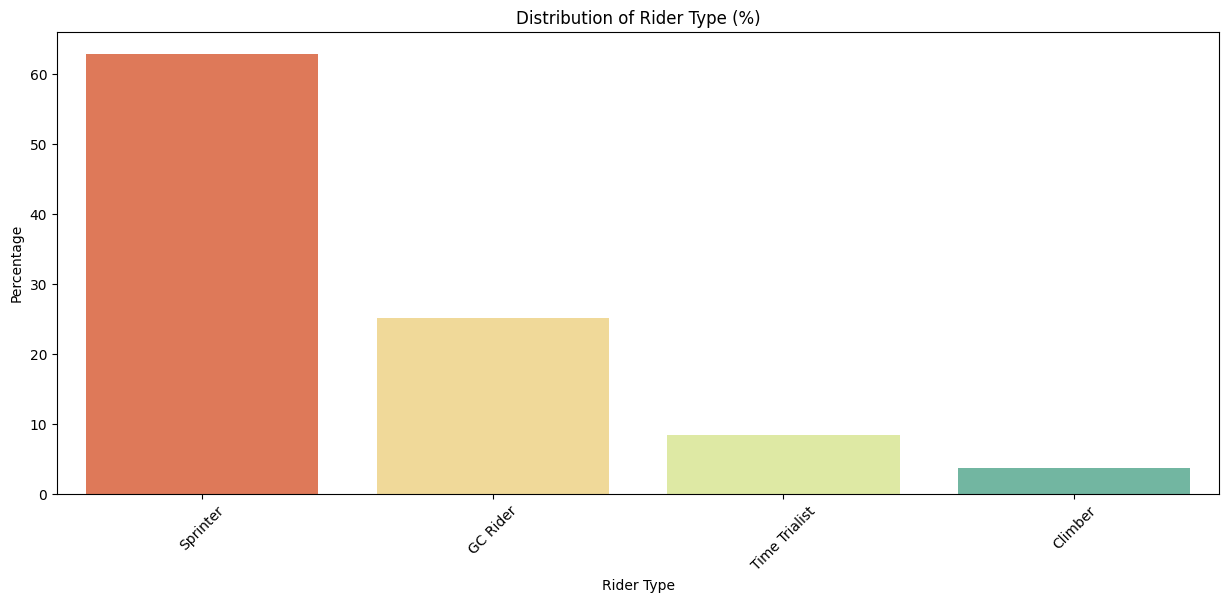

In [29]:
plt.figure(figsize=(15, 6))
total_count = len(df)  
target_counts = df['RiderType'].value_counts(normalize=True) * 100  
sns.barplot(x=target_counts.index, y=target_counts.values, palette='Spectral')
plt.xlabel('Rider Type')
plt.ylabel('Percentage')
plt.title('Distribution of Rider Type (%)')
plt.xticks(rotation=45)  
plt.show()

In [30]:
df['RiderType'].value_counts()

RiderType
Sprinter         328
GC Rider         131
Time Trialist     44
Climber           19
Name: count, dtype: int64

# Data Preprocessing

## Handling Missing Values

In [31]:
# Prepare data: Extract relevant columns, perform one-hot encoding, and set index to 'Rider'.
df_missing = df.drop(['Course', 'Year', 'Country', 'Team'], axis=1)
df_missing = pd.get_dummies(df_missing, columns=['Type', 'RiderType'], dtype=int)
df_missing.set_index('Rider', inplace=True)

# Separate 'Weight' column from the dataframe and handle missing 'Height' data.
weight = df_missing.pop('Weight')
missing_height_data = df_missing[df_missing['Height'].isnull()]
non_missing_height_data = df_missing.dropna(subset=['Height'])

# Train a linear regression model to predict missing 'Height' values.
height_model = LinearRegression()
height_model.fit(non_missing_height_data.drop(columns=['Height']), non_missing_height_data['Height'])
missing_height_data['Height'] = height_model.predict(missing_height_data.drop(columns=['Height']))

# Combine data with filled 'Height' values and restore 'Weight' column.
filled_data = pd.concat([non_missing_height_data, missing_height_data])
filled_data['Weight'] = weight

# Handle missing 'Weight' data and train a model to predict missing values.
missing_weight_data = filled_data[filled_data['Weight'].isnull()]
non_missing_weight_data = filled_data.dropna(subset=['Weight'])

weight_model = LinearRegression()
weight_model.fit(non_missing_weight_data.drop(columns=['Weight']), non_missing_weight_data['Weight'])
missing_weight_data['Weight'] = weight_model.predict(missing_weight_data.drop(columns=['Weight']))

# Combine data with filled 'Weight' values and reset index.
filled_data = pd.concat([non_missing_weight_data, missing_weight_data])
filled_data.reset_index(inplace=True)

# Update original dataframe by dropping old 'Weight' and 'Height' columns, then merge with filled data.
df = df.drop(columns=['Weight', 'Height'], axis=1)
df = pd.merge(df, filled_data[['Rider', 'Weight', 'Height']], on='Rider', how='left')
df.head()

,Year,Course,Distance,Type,Rider,Rank,DistanceKilometer,PersonalAvgPace,Team,Age,Country,Max_Score,RiderType,Weight,Height
0,1927,Evian to Pontarlier,213,Time trial,Adelin Benoit,5,5398.0,26.587,ALCYON-DUNLOP,27,Belgium,1549,Sprinter,72.526161,170.965585
1,1951,Dijon to Paris,322,Plain stage,Adolphe Deledda,32,4690.0,32.458,EST-SUD EST,32,France,1606,Sprinter,71.828341,172.963349
2,1988,Luz Ardiden to Pau,35,Plain stage,Adri Van Der Poel,84,3286.0,38.190,P.D.M,29,Netherlands,9212,Sprinter,70.000000,181.000000
3,1965,Perpignan to Montpellier,164,Plain stage,Adriano Durante,73,4188.0,35.445,MOLTENI-IGNIS,25,Italy,3392,Sprinter,72.978396,177.918018
4,1934,Ax-les-Thermes to Luchon,165,Mountain stage,Adriano Vignoli,15,4470.0,29.880,ITALIE,27,Italy,693,Sprinter,69.360215,171.329990


In [32]:
df.isnull().sum()

Year                 0
Course               0
Distance             0
Type                 0
Rider                0
Rank                 0
DistanceKilometer    0
PersonalAvgPace      0
Team                 0
Age                  0
Country              0
Max_Score            0
RiderType            0
Weight               0
Height               0
dtype: int64

In [33]:
rider_type = df['RiderType']
df = df.drop('RiderType',axis=1)
df = df.drop(['Course','Team','Country'], axis=1)
df = pd.get_dummies(df, columns=['Type'], dtype=int)
df.set_index('Rider', inplace=True)
df['RiderType'] = list(rider_type)
df.head()

,Year,Distance,Rank,DistanceKilometer,PersonalAvgPace,Age,Max_Score,Weight,Height,Type_Hilly stage,Type_Mountain stage,Type_Other,Type_Plain stage,Type_Time trial,RiderType
Rider,,,,,,,,,,,,,,,
Adelin Benoit,1927,213,5,5398.0,26.587,27,1549,72.526161,170.965585,0,0,0,0,1,Sprinter
Adolphe Deledda,1951,322,32,4690.0,32.458,32,1606,71.828341,172.963349,0,0,0,1,0,Sprinter
Adri Van Der Poel,1988,35,84,3286.0,38.190,29,9212,70.000000,181.000000,0,0,0,1,0,Sprinter
Adriano Durante,1965,164,73,4188.0,35.445,25,3392,72.978396,177.918018,0,0,0,1,0,Sprinter
Adriano Vignoli,1934,165,15,4470.0,29.880,27,693,69.360215,171.329990,0,1,0,0,0,Sprinter


## Skewness

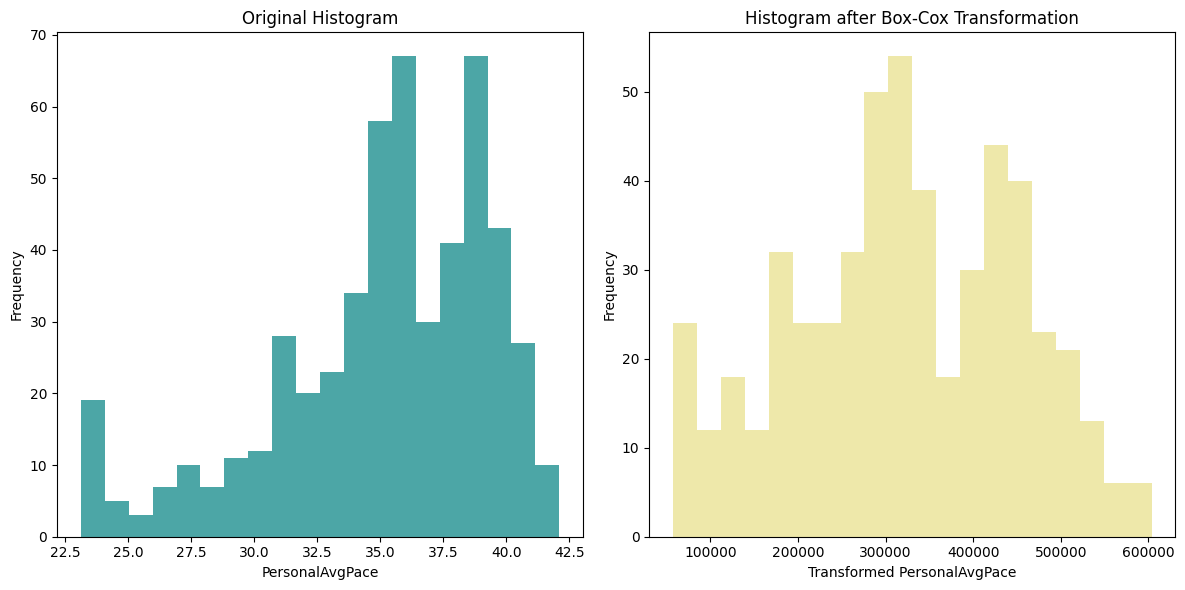

In [34]:
transformed_data, lambda_value = boxcox(df['PersonalAvgPace'])

# Original histogram
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df['PersonalAvgPace'], bins=20, color='teal', alpha=0.7)
plt.title('Original Histogram')
plt.xlabel('PersonalAvgPace')
plt.ylabel('Frequency')

df['PersonalAvgPace'] = transformed_data

# Histogram after Box-Cox transformation
plt.subplot(1, 2, 2)
plt.hist(transformed_data, bins=20, color='palegoldenrod')
plt.title('Histogram after Box-Cox Transformation')
plt.xlabel('Transformed PersonalAvgPace')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [35]:
height = df['Height'] / 100  
weight = df['Weight']

bmi = weight / (height ** 2)

df['BMI'] = bmi
df.drop(['Height', 'Weight'], axis=1, inplace=True)

In [36]:
from sklearn.preprocessing import StandardScaler
selected_columns = ['Rank', 'PersonalAvgPace', 'DistanceKilometer', 'Max_Score', 'BMI', 'Age']
selected_df = df[selected_columns]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(selected_df)

scaled_df = pd.DataFrame(scaled_features, columns=selected_columns)

def detect_outliers_std(df):
    outliers = {}
    for column in df.columns:
        std_dev = df[column].std()
        
        outlier_indices = df.index[np.abs(df[column] - df[column].mean()) > 3 * std_dev]
        
        outliers[column] = {
            'indices': outlier_indices,
            'count': len(outlier_indices)
        }
    return outliers

outliers = detect_outliers_std(selected_df)

outlier_indices = []
for data in outliers.values():
    outlier_indices.extend(data['indices'])

df = df.drop(outlier_indices, axis=0)
df.shape

(510, 14)

In [37]:
df.columns

Index(['Year', 'Distance', 'Rank', 'DistanceKilometer', 'PersonalAvgPace',
       'Age', 'Max_Score', 'Type_Hilly stage', 'Type_Mountain stage',
       'Type_Other', 'Type_Plain stage', 'Type_Time trial', 'RiderType',
       'BMI'],
      dtype='object')

In [38]:
df.sample(n=5)

,Year,Distance,Rank,DistanceKilometer,PersonalAvgPace,Age,Max_Score,Type_Hilly stage,Type_Mountain stage,Type_Other,Type_Plain stage,Type_Time trial,RiderType,BMI
Rider,,,,,,,,,,,,,,
Régis Simon,1985,83,100,4109.0,310891.394694,27,877,0,1,0,0,0,Sprinter,22.680158
Paul Wellens,1978,221,6,3908.0,326477.109217,26,1927,1,0,0,0,0,GC Rider,21.917935
Ercole Baldini,1959,243,6,4358.0,297424.223356,26,2818,0,1,0,0,0,Time Trialist,22.616610
Edward Vissers,1939,311,5,4224.0,201400.346196,27,1320,0,1,0,0,0,Sprinter,23.030045
Gilberto Simoni,2003,1915,84,3427.0,479924.092919,32,4508,0,0,0,0,1,GC Rider,20.415225


# Model

In [39]:
X, y = df.drop('RiderType', axis=1), df['RiderType']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Due to the imbalanced class distribution in the dataset, one of the crucial steps is to perform resampling. 
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)

--- RandomForestClassifier ---
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters: {'n_estimators': 150}
Best Estimator: RandomForestClassifier(n_estimators=150)
--- KNeighborsClassifier ---
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters: {'n_neighbors': 3}
Best Estimator: KNeighborsClassifier(n_neighbors=3)
--- SVC ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'C': 100, 'gamma': 'auto'}
Best Estimator: SVC(C=100, gamma='auto')
--- GradientBoostingClassifier ---
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'learning_rate': 0.1, 'n_estimators': 150}
Best Estimator: GradientBoostingClassifier(n_estimators=150)


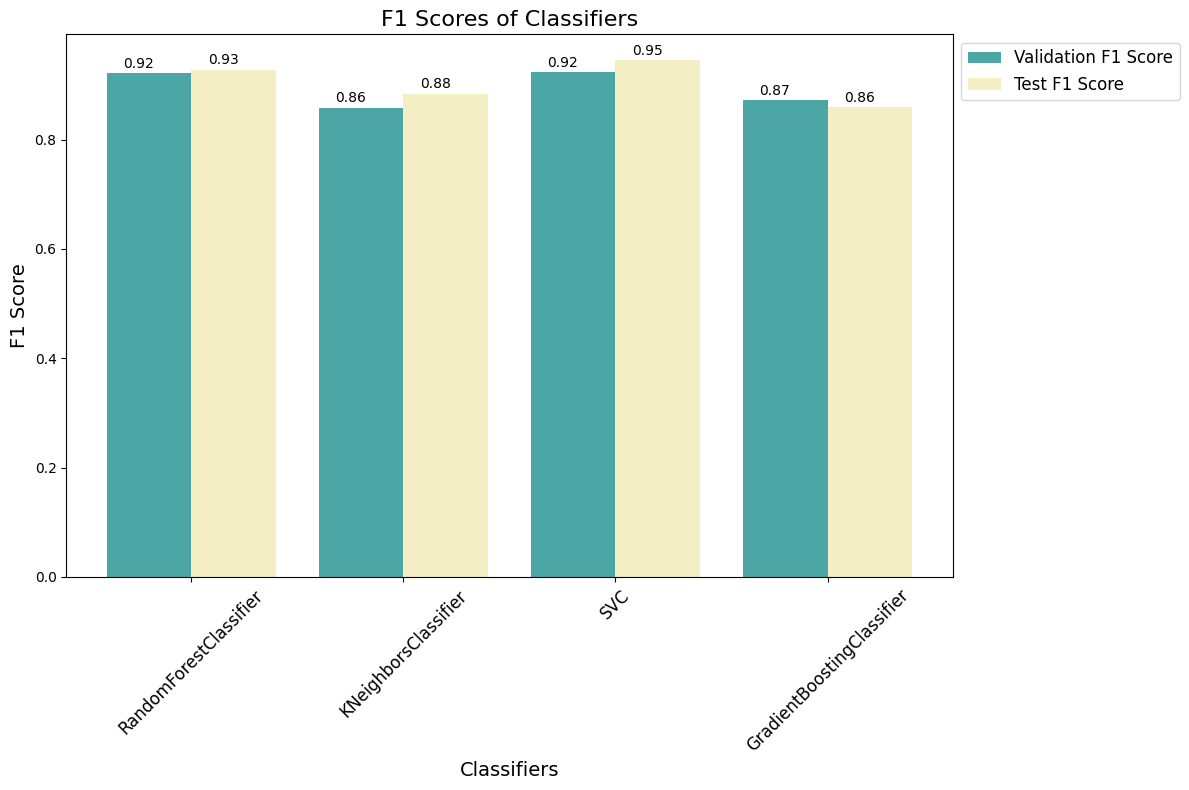

In [40]:
classifiers = {
    'RandomForestClassifier': {'model': RandomForestClassifier(), 'params': {'n_estimators': [50, 100, 150]}},
    'KNeighborsClassifier': {'model': KNeighborsClassifier(), 'params': {'n_neighbors': [3, 5, 7]}},
    'SVC': {'model': SVC(), 'params': {'C': [1, 10, 100], 'gamma': ['scale', 'auto']}},
    'GradientBoostingClassifier': {'model': GradientBoostingClassifier(), 'params': {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 1]}}
}
results = {}

for name, clf_info in classifiers.items():
    print(f"--- {name} ---")
    clf = clf_info['model']
    params = clf_info['params']
    
    grid_search = GridSearchCV(clf, params, cv=5, scoring='accuracy', verbose=1)
    grid_search.fit(X_train, y_train)
    
    best_clf = grid_search.best_estimator_
    print("Best Parameters:", grid_search.best_params_)
    print("Best Estimator:", best_clf)
    
    y_pred_val = best_clf.predict(X_val)
    val_report = classification_report(y_val, y_pred_val, output_dict=True)
    
    y_pred_test = best_clf.predict(X_test)
    test_report = classification_report(y_test, y_pred_test, output_dict=True)
    
    results[name] = {
        'best_params': grid_search.best_params_,
        'validation_report': val_report,
        'test_report': test_report,
        'validation_f1_score': f1_score(y_val, y_pred_val, average='macro'),
        'test_f1_score': f1_score(y_test, y_pred_test, average='macro')
    }

results_df = pd.DataFrame(results).transpose()

plt.figure(figsize=(12, 8))
colors = ['teal', 'palegoldenrod']
bar_width = 0.4
index = np.arange(len(results_df.index))
plt.bar(index, results_df['validation_f1_score'], color=colors[0], width=bar_width, label='Validation F1 Score', alpha=0.7)
plt.bar(index + bar_width, results_df['test_f1_score'], color=colors[1], width=bar_width, label='Test F1 Score', alpha=0.7)

for i, v in enumerate(results_df['validation_f1_score']):
    plt.text(i - 0.05, v + 0.01, str(round(v, 2)), color='black', ha='center')
for i, v in enumerate(results_df['test_f1_score']):
    plt.text(i + bar_width - 0.05, v + 0.01, str(round(v, 2)), color='black', ha='center')

plt.title('F1 Scores of Classifiers', fontsize=16)
plt.xlabel('Classifiers', fontsize=14)
plt.ylabel('F1 Score', fontsize=14)
plt.xticks(index + bar_width / 2, results_df.index, rotation=45, fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.show()

I've thoroughly enjoyed working on this project. It would have been even more exciting if we had access to additional data detailing the power output, heart rate, and other metrics for each cyclist during their race. With such comprehensive data, we could delve deeper into building models and uncovering fascinating insights among the variables.🙂 

As I'm relatively new to data science, I'd greatly appreciate any advice or insights you might have to offer at this point. Thank you!